# **CIS 545 Final Project - Team SSH (Suvas Kota, Sherie Pan, Hoang Le)** 


# **Introduction**


The goal of this project is to explore the relationship between important factors that may define a country’s level of development - climate change impact, healthcare infrastructure, and education/employment - and the country’s GDP per capita as a proxy for growth. We aim to build robust models to predict GDP per capita using these factors and in the process, elucidate the factors that can most impact a country’s GDP per capita growth, and consequently development.

By April 9th, only [0.2%](https://www.nytimes.com/interactive/2021/03/31/world/global-vaccine-supply-inequity.html ) of the global supply of COVID-19 vaccines had made it to lowest-income countries and less than 25% to low-middle income countries, yet these countries represent an immense majority of the global population, including countries like India, Vietnam, and Nigeria. This disproportionate distribution of the vaccine, and hence a country's ability to respond to the pandemic, is indicative of an underlying issue among countries: the growing economic inequality between the most developed and least developed countries. 
	
Not surprisingly, this inequity manifests at many different facets, most prominently within the environmental, social, and health contexts for each country. These factors, together, are important for defining a country’s development and this project aims to elucidate the relationship between these three factors and the economic growth of a country, which we represent with GDP. We also aim to extrapolate which one of these three aspects might be the largest factor in determining the economic state of a country. 

Outline of Project:
 

1.   Acquire and Wrangle Data from World Bank and WHO Data 
2.   Exploratory Data Analysis
3. Transforming Data for ML Models
4.   Building Regression Models and Neural Network
5.   Conclusion





# **Section 0: Initialization**

In [1]:
### Install required packages
%%capture
!pip install pandasql

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandasql as ps
import re
import seaborn as sn 

# **Section 1: Loading and wrangling the World Bank and WHO Data**

### 1.1 Creating Links and Downloading Datasets


We begin this section with retrieving datasets from both the [World Bank](https://databank.worldbank.org/reports.aspx?source=2&series=EN.ATM.GHGT.KT.CE#) and the [World Health Organization](https://apps.who.int/gho/data/node.main) (WHO), both of which contain vast collection of datsets on country development specific and healthcare variables. We have also downloaded both a list of the least developed countries and a list of low and middle income countries that we will use to compare the least developed to the highest income countries (will extrapolate middle-high and high income countries by using a right exclusive join). 

Additionally, to make access to data easier and consistent, we decided to download them and create links to them.

In [3]:
# Load in aggregated World Bank Data CSVs:
world_bank_1_df = pd.read_csv("https://raw.githubusercontent.com/suvaskota/Cis545-Datasets/main/world_bank.csv")
world_bank_2_df = pd.read_csv("https://raw.githubusercontent.com/suvaskota/Cis545-Datasets/main/worldbank_2.csv")

tb_df = pd.read_csv("https://raw.githubusercontent.com/suvaskota/Cis545-Datasets/main/TB_INCIDENCE.csv")

health_expenditures_df = pd.read_csv("https://raw.githubusercontent.com/suvaskota/Cis545-Datasets/main/health%20expenditure.csv")

low_and_middle_income_df = pd.read_csv("https://raw.githubusercontent.com/suvaskota/Cis545-Datasets/main/least_developed.csv", header=None)
least_developed_df = pd.read_csv("https://raw.githubusercontent.com/suvaskota/Cis545-Datasets/main/least_developed_un.csv", header=None)

urban_sprawl_df = pd.read_csv('https://raw.githubusercontent.com/suvaskota/Cis545-Datasets/main/urban_sprawl_annual_percent.csv')

measles_vaccinations_df = pd.read_csv('https://raw.githubusercontent.com/suvaskota/Cis545-Datasets/main/percent_children_vaccinated_with_measles.csv')

forest_area_df = pd.read_csv('https://raw.githubusercontent.com/suvaskota/Cis545-Datasets/main/forest_area_sqkm.csv')

adolescent_fertility_df = pd.read_csv('https://raw.githubusercontent.com/suvaskota/Cis545-Datasets/main/adolescent_fertility_birth_rate_per_1000.csv')

age_dependency_df = pd.read_csv('https://raw.githubusercontent.com/suvaskota/Cis545-Datasets/main/age_dependency_ratio.csv')

We choose the following features for the listed reasons to represent each subgroup of features:

**Climate Change/Environmental Data**

1) CO2 Emissions - this is one of the most direct information on the human impact on climate change.

2) Forest Area - we will use this to look at the rate of deforestation, which has an impact on climate change and a country's vulnerability to the effects of global warming. 

3) Urban Population Growth - this is a direct measure of the rate of urban sprawl, which is a proxy for habitat destruction and emissions associated with urban living.

**Social Factor Data**

1) Percent of Salaried Workers - this represents the proportion of all workers which receive salaries, which gives us insight into job markets, types of employment available and the state of employment regulations.

2) Adolescent Fertility - this is one of the most widely used indicators for development and should give us insight into demographic differences and contraceptive access.

3) Age Dependency Ratio - this is another proxy for demographics and will allow for us to look at the number of dependents (child or elderly) per 100 people of the working age population 

**Health and Disease Factors**

1) Tuberculosis Incidence - this is one of the most dangerous infectious diseases that still affects millions at a global scale. This dataset will give us insight into how different countries are addressing this and by extension, other infectious diseases.

2) Healthcare Expenditures Per Capita - this should be a direct measure of how much governments spend on healthcare infrastructure

3) Percentage of Children Immunized for Measles - this will give us insight into how widely available basic vaccinations are within different countries


### 1.2 Separating World Bank Data

These features retrieved from the World Bank were done so together, so we now need to seperate the data so each feature has its own dataset - each row corresponds to one of the features in the column ['Series Name']. We want each feature to have its own dataframe for the purpose of exploratoy data analysis. We also cleaned up the titles for later use.

In [4]:
# The years were named in an eccentric manner so we reformat the years into more readable formats

original_columns = list(world_bank_1_df.columns[4:21])
new_columns = [i.split(' ')[0] for i in original_columns]

world_bank_1_df = world_bank_1_df.rename(columns = dict(zip(original_columns, new_columns)))
world_bank_2_df = world_bank_2_df.rename(columns = dict(zip(original_columns, new_columns)))
forest_area_df = forest_area_df.rename(columns = dict(zip(original_columns, new_columns)))
urban_sprawl_df = urban_sprawl_df.rename(columns = dict(zip(original_columns, new_columns)))
adolescent_fertility_df = adolescent_fertility_df.rename(columns = dict(zip(original_columns, new_columns)))
age_dependency_df = age_dependency_df.rename(columns = dict(zip(original_columns, new_columns)))
health_expenditures_df = health_expenditures_df.rename(columns = dict(zip(original_columns, new_columns)))
measles_vaccinations_df = measles_vaccinations_df.rename(columns = dict(zip(original_columns, new_columns)))

In [5]:
# Separate each feature into its own dataframe for the purpose of exploratory data analysis

gdp_df = world_bank_2_df[world_bank_2_df['Series Name'] == 'GDP per capita growth (annual %)']
co2_emissions_df = world_bank_1_df[world_bank_1_df['Series Name'] == 'CO2 emissions (metric tons per capita)']
forest_area_df = forest_area_df[forest_area_df['Series Name'] == 'Forest area (sq. km)']
urban_sprawl_df = urban_sprawl_df[urban_sprawl_df['Series Name'] == 'Urban population growth (annual %)']
salaried_workers_df = world_bank_2_df[world_bank_2_df['Series Name'] == 'Wage and salaried workers, total (% of total employment) (modeled ILO estimate)']
adolescent_fertility_df = adolescent_fertility_df[adolescent_fertility_df['Series Name'] == 'Adolescent fertility rate (births per 1,000 women ages 15-19)']
age_dependency_df = age_dependency_df[age_dependency_df['Series Name'] == 'Age dependency ratio (% of working-age population)']
measles_vaccinations_df = measles_vaccinations_df[measles_vaccinations_df['Series Name'] == 'Immunization, measles (% of children ages 12-23 months)']
population_df = world_bank_1_df[world_bank_1_df['Series Name'] == 'Population, total']

###1.3 Cleaning the Data

The data from the World Bank contains a few things that we need to address and clean: 

1.   For each of the features that we have gathered from the World Bank, we are replacing the cells with missing data with NaNs
2.   We proceed to cast all the values to floats
3.   Round all the values for coherence and computation


In [6]:
years = ['2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', 
         '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016']

In [7]:
# GDP per capita growth (annual %)
gdp_df = gdp_df.drop(columns=['Series Name', 'Series Code']).reset_index(drop=True)

for year in years:
  gdp_df[year] = gdp_df[year].apply(lambda x: np.NaN if x == ".." else x)
  gdp_df[year] = gdp_df[year].astype('float', copy=True)

gdp_df = gdp_df.round(3)
gdp_df

Country Name Country Code  ...   2015   2016
0                                   Afghanistan          AFG  ... -1.623 -0.542
1                                       Albania          ALB  ...  2.517  3.480
2                                       Algeria          DZA  ...  1.600  1.105
3                                American Samoa          ASM  ...  1.366 -2.645
4                                       Andorra          AND  ...  2.997  4.668
..                                          ...          ...  ...    ...    ...
259                          Sub-Saharan Africa          SSF  ...  0.045 -1.517
260  Sub-Saharan Africa (excluding high income)          SSA  ...  0.035 -1.542
261   Sub-Saharan Africa (IDA & IBRD countries)          TSS  ...  0.045 -1.517
262                         Upper middle income          UMC  ...  2.729  3.145
263                                       World          WLD  ...  1.686  1.426

[264 rows x 19 columns]

In [8]:
# CO2 emissions (metric tons per capita)
co2_emissions_df = co2_emissions_df.drop(columns=['Series Name', 'Series Code']).reset_index(drop=True)

for year in years:
  co2_emissions_df[year] = co2_emissions_df[year].apply(lambda x: np.NaN if x == ".." else x)
  co2_emissions_df[year] = co2_emissions_df[year].astype('float', copy=True)

co2_emissions_df = co2_emissions_df.round(3)
co2_emissions_df

Country Name Country Code  ...   2015   2016
0                                   Afghanistan          AFG  ...  0.263  0.245
1                                       Albania          ALB  ...  1.603  1.577
2                                       Algeria          DZA  ...  3.855  3.699
3                                American Samoa          ASM  ...    NaN    NaN
4                                       Andorra          AND  ...  5.970  6.072
..                                          ...          ...  ...    ...    ...
259                          Sub-Saharan Africa          SSF  ...  0.835  0.834
260  Sub-Saharan Africa (excluding high income)          SSA  ...  0.832  0.831
261   Sub-Saharan Africa (IDA & IBRD countries)          TSS  ...  0.835  0.834
262                         Upper middle income          UMC  ...  6.071  5.980
263                                       World          WLD  ...  4.638  4.555

[264 rows x 19 columns]

In [9]:
# Forest area (sq. km)
forest_area_df = forest_area_df.drop(columns=['Series Name', 'Series Code']).reset_index(drop=True)

for year in years:
  forest_area_df[year] = forest_area_df[year].apply(lambda x: np.NaN if x == ".." else x)
  forest_area_df[year] = forest_area_df[year].astype('float', copy=True)

forest_area_df = forest_area_df.round(3)
forest_area_df

Country Name  ...          2016
0                                     Argentina  ...  2.901000e+05
1                                     Australia  ...  1.340372e+06
2                                        Brazil  ...  5.020821e+06
3                                         China  ...  2.124599e+06
4                                        France  ...  1.691940e+05
..                                          ...  ...           ...
259                          Sub-Saharan Africa  ...  6.430837e+06
260  Sub-Saharan Africa (excluding high income)  ...  6.430117e+06
261   Sub-Saharan Africa (IDA & IBRD countries)  ...  6.430837e+06
262                         Upper middle income  ...  2.149290e+07
263                                       World  ...  3.995825e+07

[264 rows x 19 columns]

In [10]:
# Urban population growth (annual %)
urban_sprawl_df = urban_sprawl_df.drop(columns=['Series Name', 'Series Code']).reset_index(drop=True)

for year in years:
  urban_sprawl_df[year] = urban_sprawl_df[year].apply(lambda x: np.NaN if x == ".." else x)
  urban_sprawl_df[year] = urban_sprawl_df[year].astype('float', copy=True)

urban_sprawl_df = urban_sprawl_df.round(3)
urban_sprawl_df

Country Name Country Code  ...   2015   2016
0                                     Argentina          ARG  ...  1.216  1.193
1                                     Australia          AUS  ...  1.555  1.677
2                                        Brazil          BRA  ...  1.163  1.140
3                                         China          CHN  ...  2.770  2.744
4                                        France          FRA  ...  0.684  0.592
..                                          ...          ...  ...    ...    ...
259                          Sub-Saharan Africa          SSF  ...  4.144  4.117
260  Sub-Saharan Africa (excluding high income)          SSA  ...  4.150  4.124
261   Sub-Saharan Africa (IDA & IBRD countries)          TSS  ...  4.144  4.117
262                         Upper middle income          UMC  ...  2.160  2.119
263                                       World          WLD  ...  2.032  2.019

[264 rows x 19 columns]

In [11]:
# Wage and salaried workers (% of total employment) (modeled ILO estimate)
salaried_workers_df = salaried_workers_df.drop(columns=['Series Name', 'Series Code']).reset_index(drop=True)

for year in years:
  salaried_workers_df[year] = salaried_workers_df[year].apply(lambda x: np.NaN if x == ".." else x)
  salaried_workers_df[year] = salaried_workers_df[year].astype('float', copy=True)

salaried_workers_df = salaried_workers_df.round(3)
salaried_workers_df

Country Name Country Code  ...    2015    2016
0                                   Afghanistan          AFG  ...  15.790  16.500
1                                       Albania          ALB  ...  41.190  41.400
2                                       Algeria          DZA  ...  68.650  68.460
3                                American Samoa          ASM  ...     NaN     NaN
4                                       Andorra          AND  ...     NaN     NaN
..                                          ...          ...  ...     ...     ...
259                          Sub-Saharan Africa          SSF  ...  23.691  23.890
260  Sub-Saharan Africa (excluding high income)          SSA  ...  23.604  23.805
261   Sub-Saharan Africa (IDA & IBRD countries)          TSS  ...  23.691  23.890
262                         Upper middle income          UMC  ...  58.018  58.156
263                                       World          WLD  ...  52.191  52.511

[264 rows x 19 columns]

In [12]:
# Adolescent fertility rate (births per 1,000 women ages 15-19)
adolescent_fertility_df = adolescent_fertility_df.drop(columns=['Series Name', 'Series Code']).reset_index(drop=True)

for year in years:
  adolescent_fertility_df[year] = adolescent_fertility_df[year].apply(lambda x: np.NaN if x == ".." else x)
  adolescent_fertility_df[year] = adolescent_fertility_df[year].astype('float', copy=True)

adolescent_fertility_df = adolescent_fertility_df.round(3)
adolescent_fertility_df

Country Name Country Code     2000  ...     2014     2015     2016
0           Afghanistan          AFG  153.951  ...   77.459   73.126   68.794
1               Albania          ALB   19.037  ...   20.705   20.692   20.680
2               Algeria          DZA   11.756  ...   10.989   10.705   10.422
3        American Samoa          ASM      NaN  ...      NaN      NaN      NaN
4               Andorra          AND      NaN  ...      NaN      NaN      NaN
..                  ...          ...      ...  ...      ...      ...      ...
237  West Bank and Gaza          PSE   81.130  ...   58.974   58.065   57.156
238               World          WLD   55.849  ...   45.610   45.146   44.565
239         Yemen, Rep.          YEM   95.856  ...   64.744   63.280   61.816
240              Zambia          ZMB  141.552  ...   92.282   89.128   85.973
241            Zimbabwe          ZWE  108.091  ...  109.293  107.555  105.818

[242 rows x 19 columns]

In [13]:
# Age dependency ratio (% of working-age population)
age_dependency_df = age_dependency_df.drop(columns=['Series Name', 'Series Code']).reset_index(drop=True)

for year in years:
  age_dependency_df[year] = age_dependency_df[year].apply(lambda x: np.NaN if x == ".." else x)
  age_dependency_df[year] = age_dependency_df[year].astype('float', copy=True)

age_dependency_df = age_dependency_df.round(3)
age_dependency_df

Country Name Country Code     2000  ...    2014    2015    2016
0           Afghanistan          AFG  103.326  ...  91.376  88.769  86.571
1               Albania          ALB   59.586  ...  44.711  44.017  44.002
2               Algeria          DZA   62.886  ...  51.597  52.725  53.908
3        American Samoa          ASM      NaN  ...     NaN     NaN     NaN
4               Andorra          AND      NaN  ...     NaN     NaN     NaN
..                  ...          ...      ...  ...     ...     ...     ...
237  West Bank and Gaza          PSE  100.398  ...  76.751  75.764  74.945
238               World          WLD   60.110  ...  54.022  54.061  54.202
239         Yemen, Rep.          YEM  105.883  ...  77.809  76.766  75.900
240              Zambia          ZMB   96.273  ...  93.136  91.866  90.780
241            Zimbabwe          ZWE   84.804  ...  79.718  79.514  79.195

[242 rows x 19 columns]

In [14]:
# Current health expenditure per capita, PPP (current international $)
health_expenditures_df = health_expenditures_df.drop(columns=['Series Name', 'Series Code']).reset_index(drop=True)

for year in years:
  health_expenditures_df[year] = health_expenditures_df[year].apply(lambda x: np.NaN if x == ".." else x)
  health_expenditures_df[year] = health_expenditures_df[year].astype('float', copy=True)

health_expenditures_df = salaried_workers_df.round(3)
health_expenditures_df

Country Name Country Code  ...    2015    2016
0                                   Afghanistan          AFG  ...  15.790  16.500
1                                       Albania          ALB  ...  41.190  41.400
2                                       Algeria          DZA  ...  68.650  68.460
3                                American Samoa          ASM  ...     NaN     NaN
4                                       Andorra          AND  ...     NaN     NaN
..                                          ...          ...  ...     ...     ...
259                          Sub-Saharan Africa          SSF  ...  23.691  23.890
260  Sub-Saharan Africa (excluding high income)          SSA  ...  23.604  23.805
261   Sub-Saharan Africa (IDA & IBRD countries)          TSS  ...  23.691  23.890
262                         Upper middle income          UMC  ...  58.018  58.156
263                                       World          WLD  ...  52.191  52.511

[264 rows x 19 columns]

In [15]:
# Immunization, measles (% of children ages 12-23 months)
measles_vaccinations_df = measles_vaccinations_df.drop(columns=['Series Name', 'Series Code']).reset_index(drop=True)

for year in years:
  measles_vaccinations_df[year] = measles_vaccinations_df[year].apply(lambda x: np.NaN if x == ".." else x)
  measles_vaccinations_df[year] = measles_vaccinations_df[year].astype('float', copy=True)

measles_vaccinations_df = measles_vaccinations_df.round(3)
measles_vaccinations_df

Country Name Country Code  ...    2015    2016
0                                     Argentina          ARG  ...  89.000  90.000
1                                     Australia          AUS  ...  95.000  95.000
2                                        Brazil          BRA  ...  96.000  95.000
3                                         China          CHN  ...  99.000  99.000
4                                        France          FRA  ...  91.000  90.000
..                                          ...          ...  ...     ...     ...
259                          Sub-Saharan Africa          SSF  ...  68.144  68.381
260  Sub-Saharan Africa (excluding high income)          SSA  ...  68.130  68.370
261   Sub-Saharan Africa (IDA & IBRD countries)          TSS  ...  68.144  68.381
262                         Upper middle income          UMC  ...  94.775  94.934
263                                       World          WLD  ...  84.949  85.204

[264 rows x 19 columns]

In [16]:
# Total population - this data is used for normalazing the TB data later on
population_df = population_df.drop(columns=['Series Name', 'Series Code']).reset_index(drop=True)

for year in years:
  population_df[year] = population_df[year].apply(lambda x: np.NaN if x == ".." else x)
  population_df[year] = population_df[year].astype('float', copy=True)

population_df

Country Name  ...          2016
0                                   Afghanistan  ...  3.538313e+07
1                                       Albania  ...  2.876101e+06
2                                       Algeria  ...  4.055140e+07
3                                American Samoa  ...  5.574100e+04
4                                       Andorra  ...  7.729700e+04
..                                          ...  ...           ...
259                          Sub-Saharan Africa  ...  1.022527e+09
260  Sub-Saharan Africa (excluding high income)  ...  1.021168e+09
261   Sub-Saharan Africa (IDA & IBRD countries)  ...  1.022527e+09
262                         Upper middle income  ...  2.795835e+09
263                                       World  ...  7.424286e+09

[264 rows x 19 columns]

### 1.4 Cleaning and Reformatting WHO Data
Our data on TB Incidence is from WHO, and we want to integrate this dataset with the rest of the World Bank data above, but we need a standardized way to identify countries: the country code. Since the WHO data doesn't include this, we must convert all the WHO data's country names to the country codes used by the World Bank data. We will initialize a dictionary with all the country codes from a representative World Bank Dataset and then come back after processing our largest dataset to analyze how we should go forward with achieving 100% conversion to country codes.

Additionally, there are quite a lot of things to clean within the TB data itself. 1) the values of the incidences are strings that are formatted like this 'mean [min - max]', so we have to use regex to extrapolate the mean and 2) we must normalize the data to the populations of each country.

#### 1.4.1 Converting Country Names to Country Codes - Part 1
We start by creating a dictionary of all the countries and their country codes from a World Bank Dataset that has the most comprehensive list of countries.

In [17]:
# Create a dictionary to convert country names from WHO data to country codes provided by World Bank datasets
country_codes = {}

def add_code(country, code):
  country = country.lower()
  if country not in country_codes:
    country_codes[country] = code

# Can use any World Bank Dataset, in this case will use co2_emissions_df
for index, row in co2_emissions_df.iterrows():
  add_code(row['Country Name'], row['Country Code'])

#### 1.4.2 TB Incidence Data

In [18]:
# Cleaning TB Incidence
tb_df = tb_df[['Country','Year','Number of incident tuberculosis cases']]
tb_df = tb_df.rename(columns={'Number of incident tuberculosis cases' : 'Cases'})
tb_df = tb_df[tb_df['Country'].notnull()]

# Similarly to Excel's pivot function, will use Pandas' built in pivot_table function
tb_df = pd.pivot_table(tb_df, values='Cases', index=['Country'], columns=['Year'], aggfunc=np.sum)
tb_df = tb_df.reset_index()
tb_df = tb_df.rename(index={'Year' : 'Index'})

# Drop 2017-2019
tb_df = tb_df.drop(columns=[2017,2018,2019])
tb_df

Year                             Country  ...                    2016
0                            Afghanistan  ...     67000 [43000-95000]
1                                Albania  ...           480 [410-550]
2                                Algeria  ...     29000 [22000-36000]
3                                Andorra  ...                 5 [4-5]
4                                 Angola  ...   105000 [68000-149000]
..                                   ...  ...                     ...
189   Venezuela (Bolivarian Republic of)  ...      10000 [7800-13000]
190                             Viet Nam  ...  181000 [114000-263000]
191                                Yemen  ...     13000 [11000-15000]
192                               Zambia  ...     61000 [40000-88000]
193                             Zimbabwe  ...     33000 [24000-42000]

[194 rows x 18 columns]

After simple cleaning, we use regex to tranform the values into usable strings that can then be easily converted to floats.

In [19]:
# Using regex to extrapolate out the mean of the given range and convert to int

def remove_brackets(text):
    # Not all values are strings 
    text = str(text)
    
    # NaN here is a string in the dataset
    if text.lower() == 'nan':
      return np.NaN
    else:
      brackets = '\\[.*?\\]'

      x_no_brackets = re.sub(brackets, '', text)
      x_strip1 = str.strip(x_no_brackets)
      # To handle empty spaces in between
      x_strip2 = x_strip1.replace(" ", "")
      return str(x_strip2)

In [20]:
# Removing brackets from tb_df and converting all values to floats
for i in range(2000,2017):
  tb_df[i] = tb_df[i].apply(lambda x: remove_brackets(x))
  tb_df[i] = tb_df[i].astype(np.float64)
tb_df

Year                             Country      2000  ...      2015      2016
0                            Afghanistan   39000.0  ...   65000.0   67000.0
1                                Albania     690.0  ...     480.0     480.0
2                                Algeria   23000.0  ...   30000.0   29000.0
3                                Andorra      14.0  ...       5.0       5.0
4                                 Angola   49000.0  ...  102000.0  105000.0
..                                   ...       ...  ...       ...       ...
189   Venezuela (Bolivarian Republic of)    8100.0  ...    8900.0   10000.0
190                             Viet Nam  237000.0  ...  185000.0  181000.0
191                                Yemen   20000.0  ...   13000.0   13000.0
192                               Zambia   79000.0  ...   62000.0   61000.0
193                             Zimbabwe   72000.0  ...   33000.0   33000.0

[194 rows x 18 columns]

#### 1.4.3 Converting Country Names to Country Codes - Part 2

Now we will convert country name into country code with tb_df, as it is the most exhaustive dataset from WHO (containing the most countries). We will then analyze the mismatches and see whether imputation of codes to ensure full conversion is feasible or if this requires tokenization. 

In [21]:
# Now we need to convert country name into country code

# 1. Convert country names of tb_df into codes 
def give_code(country):
  country = country.lower()
  if country in country_codes:
    return country_codes[country]
  else:
    return None 

temp = tb_df
temp['Country Code'] = temp['Country'].apply(lambda x: give_code(x)) 

# 2. Check which ones don't match and see whether we can input the codes by hand (if mismatches are small) 
#   or require tokenization (if mismatches are large)

temp2 = temp[temp['Country Code'].isnull()]
mismatched_country_list = temp2['Country']
mismatched_country_list

# 3. Adding to country_code dictionary - since there are only 27, we will add by hand - furthermore, many of these are vastly differnt,
#   or have important nuances and tokenization would not be useful 
country_codes['Bahamas'.lower()] = 'BHS'
country_codes['Bolivia (Plurinational State of)'.lower()] = 'BOL'
country_codes['Congo'.lower()] = 'COG'
country_codes['Czechia'.lower()] = 'CZE'
country_codes["Côte d'Ivoire".lower()] = 'CIV'
country_codes["Côte d’Ivoire".lower()] = 'CIV'
country_codes["Democratic People's Republic of Korea".lower()] = 'PRK'
country_codes["KOREA, DEM. PEOPLE'S REP.".lower()] = 'PRK'
country_codes["Democratic Republic of the Congo".lower()] = 'COD'
country_codes['Egypt'.lower()] = 'EGY'
country_codes['Gambia'.lower()] = 'GMB'
country_codes['Iran (Islamic Republic of)'.lower()] = 'IRN'
country_codes['Kyrgyzstan'.lower()] = 'KGZ'
country_codes["Lao People's Democratic Republic".lower()] = 'LAO'
country_codes['Micronesia (Federated States of)'.lower()] = 'FSM'
country_codes['Republic of Korea'.lower()] = 'KOR'
country_codes['Saint Kitts and Nevis'.lower()] = 'KNA'
country_codes['Saint Lucia'.lower()] = 'LCA'
country_codes['Saint Vincent and the Grenadines'.lower()] = 'VCT'
country_codes['Slovakia'.lower()] = 'SVK'
country_codes['United Kingdom of Great Britain and Northern Ireland'.lower()] = 'GBR'
country_codes['United Republic of Tanzania'.lower()] = 'TZA'
country_codes['United States of America'.lower()] = 'USA'
country_codes['Venezuela (Bolivarian Republic of)'.lower()] = 'VEN'
country_codes['Viet Nam'.lower()] = 'VNM'
country_codes['Yemen'.lower()] = 'YEM'
country_codes['Republic of Moldova'.lower()] = 'MDA'

#4. Check again to see if full coverage was achieved 

temp = tb_df
temp['Country Code'] = temp['Country'].apply(lambda x: give_code(x)) 

temp2 = temp[temp['Country Code'].isnull()]
mismatched_country_list = temp2['Country']
mismatched_country_list

#5. Set to final df

tb_df = temp
tb_df

Year                             Country      2000  ...      2016  Country Code
0                            Afghanistan   39000.0  ...   67000.0           AFG
1                                Albania     690.0  ...     480.0           ALB
2                                Algeria   23000.0  ...   29000.0           DZA
3                                Andorra      14.0  ...       5.0           AND
4                                 Angola   49000.0  ...  105000.0           AGO
..                                   ...       ...  ...       ...           ...
189   Venezuela (Bolivarian Republic of)    8100.0  ...   10000.0           VEN
190                             Viet Nam  237000.0  ...  181000.0           VNM
191                                Yemen   20000.0  ...   13000.0           YEM
192                               Zambia   79000.0  ...   61000.0           ZMB
193                             Zimbabwe   72000.0  ...   33000.0           ZWE

[194 rows x 19 columns]

We realized that tokenizing wouldn't work all too well since we have differences like 'Venezeula' vs 'Venezuela (Bolivarian Republic of)' or 'Bolivia' vs 'Bolivia (Plurinational State of)' (I was confused myself :)). So instead we wanted to take the fun route and manually encode for the new countries! The next cell simply changes the column names to strings to ensure consistency between all datasets.

In [22]:
# Finishing Up Cleaning
# Convert Columns Names to Strings

tb_df = tb_df.rename(columns={
      2000 : '2000' , 
      2001 : '2001' , 
      2002 : '2002' , 
      2003 : '2003' , 
      2004 : '2004' , 
      2005 : '2005' , 
      2006 : '2006' , 
      2007 : '2007' , 
      2008 : '2008' , 
      2009 : '2009' , 
      2010 : '2010' , 
      2011 : '2011' , 
      2012 : '2012' , 
      2013 : '2013' , 
      2014 : '2014' , 
      2015 : '2015' , 
      2016 : '2016' , 
      2017 : '2017' ,})

#### 1.4.4 Converting Country Names to Codes: List of Developing Countries

We wanted to standardize the lists of least_developed_df and low_middle_income_df and convert into country codes. We also do the equivalent of a right exclusive join to get a list of the highest income countries (and remove the bottom of the list which only contains aggregate groups of countries like Sub-Saharan Africa).

In [23]:
# Add country codes to table of least developed countries
least_developed_df = least_developed_df.rename(columns={0 : 'Country'})
least_developed_df['Country Code'] = least_developed_df['Country'].apply(lambda x: give_code(x)) 
least_developed_df

Country Country Code
0                AFGHANISTAN          AFG
1                     ANGOLA          AGO
2                 BANGLADESH          BGD
3                      BENIN          BEN
4                     BHUTAN          BTN
5               BURKINA FASO          BFA
6                    BURUNDI          BDI
7                   CAMBODIA          KHM
8   CENTRAL AFRICAN REPUBLIC          CAF
9                       CHAD          TCD
10                   COMOROS          COM
11          CONGO, DEM. REP.          COD
12                  DJIBOUTI          DJI
13                   ERITREA          ERI
14                  ETHIOPIA          ETH
15               GAMBIA, THE          GMB
16                    GUINEA          GIN
17             GUINEA-BISSAU          GNB
18                     HAITI          HTI
19                  KIRIBATI          KIR
20                   LAO PDR          LAO
21                   LESOTHO          LSO
22                   LIBERIA          LBR
23                MADAGASCAR          MDG
24                    MALAWI          MWI
25                      MALI          MLI
26                MAURITANIA          MRT
27                MOZAMBIQUE          MOZ
28                   MYANMAR          MMR
29                     NEPAL          NPL
30                     NIGER          NER
31                    RWANDA          RWA
32     SAO TOME AND PRINCIPE          STP
33                   SENEGAL          SEN
34              SIERRA LEONE          SLE
35           SOLOMON ISLANDS          SLB
36                   SOMALIA          SOM
37               SOUTH SUDAN          SSD
38                     SUDAN          SDN
39                  TANZANIA          TZA
40               TIMOR-LESTE          TLS
41                      TOGO          TGO
42                    TUVALU          TUV
43                    UGANDA          UGA
44                   VANUATU          VUT
45               YEMEN, REP.          YEM
46                    ZAMBIA          ZMB

In [24]:
# Add country codes to table of low and middle income countries
low_and_middle_income_df = low_and_middle_income_df.rename(columns={0 : 'Country'})
low_and_middle_income_df['Country Code'] = low_and_middle_income_df['Country'].apply(lambda x: give_code(x)) 
low_and_middle_income_df

Country Country Code
0           AFGHANISTAN          AFG
1               ALBANIA          ALB
2               ALGERIA          DZA
3        AMERICAN SAMOA          ASM
4                ANGOLA          AGO
..                  ...          ...
130             VIETNAM          VNM
131  WEST BANK AND GAZA          PSE
132         YEMEN, REP.          YEM
133              ZAMBIA          ZMB
134            ZIMBABWE          ZWE

[135 rows x 2 columns]

In [25]:
# Get List of Non-Low-Middle Income COuntries (High Middle and High Income Countries)
# Use Any World Bank Data Frame to Get Full List of Countries like in 1.3.1
pd.set_option('display.max_rows', 10)
all_countries_df = health_expenditures_df[['Country Name','Country Code']]
high_income_df = pd.merge(left=all_countries_df, right=low_and_middle_income_df, left_on='Country Code', right_on='Country Code', how='left')
high_income_df = high_income_df[high_income_df['Country'].isnull()].drop(columns=['Country'])

# Get rid of non-countries
high_income_df = high_income_df[high_income_df.index < 216]
high_income_df




Country Name Country Code
4                  Andorra          AND
6      Antigua and Barbuda          ATG
9                    Aruba          ABW
10               Australia          AUS
11                 Austria          AUT
..                     ...          ...
204   United Arab Emirates          ARE
205         United Kingdom          GBR
206          United States          USA
207                Uruguay          URY
212  Virgin Islands (U.S.)          VIR

[82 rows x 2 columns]

#### 1.4.5 Normalizing WHO Data With World Bank Population Data

Here is an important part of the process -  normalizing the incidences for country population. We achieve this by simply merging the tb_df with population_df and dividing the incidences by each country's population per year. 

In [26]:
#Joining both tb_df with population_df to normalize values per 100,000 people

tb_pop_merged = pd.merge(left=tb_df, right=population_df, left_on='Country Code', right_on='Country Code', how='left')

for i in range(2000,2017):
  year = str(i)
  year_x = year + "_x"
  year_y = year + "_y"
  tb_pop_merged[year_x] = tb_pop_merged[year_x]/(tb_pop_merged[year_y]/100000)

tb_df = tb_pop_merged[['Country', 'Country Code', '2000_x', '2001_x', '2002_x', '2003_x', '2004_x', '2005_x', '2006_x',
       '2007_x', '2008_x', '2009_x','2010_x','2011_x','2012_x','2013_x','2014_x','2015_x', '2016_x' ]]

tb_df = tb_df.rename(columns={
      '2000_x' : '2000' , 
      '2001_x' : '2001' , 
      '2002_x' : '2002' , 
      '2003_x' : '2003' , 
      '2004_x' : '2004' , 
      '2005_x' : '2005' , 
      '2006_x' : '2006' , 
      '2007_x' : '2007' , 
      '2008_x' : '2008' , 
      '2009_x' : '2009' , 
      '2010_x' : '2010' , 
      '2011_x' : '2011' , 
      '2012_x' : '2012' , 
      '2013_x' : '2013' , 
      '2014_x' : '2014' , 
      '2015_x' : '2015' , 
      '2016_x' : '2016' ,  })

tb_df

Country Country Code  ...        2015        2016
0                           Afghanistan          AFG  ...  188.878799  189.355786
1                               Albania          ALB  ...   16.662599   16.689261
2                               Algeria          DZA  ...   75.513444   71.514170
3                               Andorra          AND  ...    6.409353    6.468556
4                                Angola          AGO  ...  365.796178  364.046314
..                                  ...          ...  ...         ...         ...
189  Venezuela (Bolivarian Republic of)          VEN  ...   29.585967   33.505126
190                            Viet Nam          VNM  ...  199.617865  193.296098
191                               Yemen          YEM  ...   49.060512   47.850042
192                              Zambia          ZMB  ...  390.443923  372.780725
193                            Zimbabwe          ZWE  ...  238.877208  235.203726

[194 rows x 19 columns]

# Section 2: Exploratory Analysis of Data


When looking at these datasets, it is important to not only look at the trends within countries or for all countries, but to look at the difference between the least developed and highest income countries. Many of these factors are related, such as health expenditure and TB incidences, which may introduce colinearity into our model. We want to explore the data by looking at each feature, and plotting for the subgroup of the least developed countries and the subgroup of the highest income countries and finally, comparing the trends between the two and extrapolating out information that may give insight into the dynamics of inequity between the two groups. 

### 2.1 EDA of Climatic Factors

#### 2.1.1 CO2 Emissions

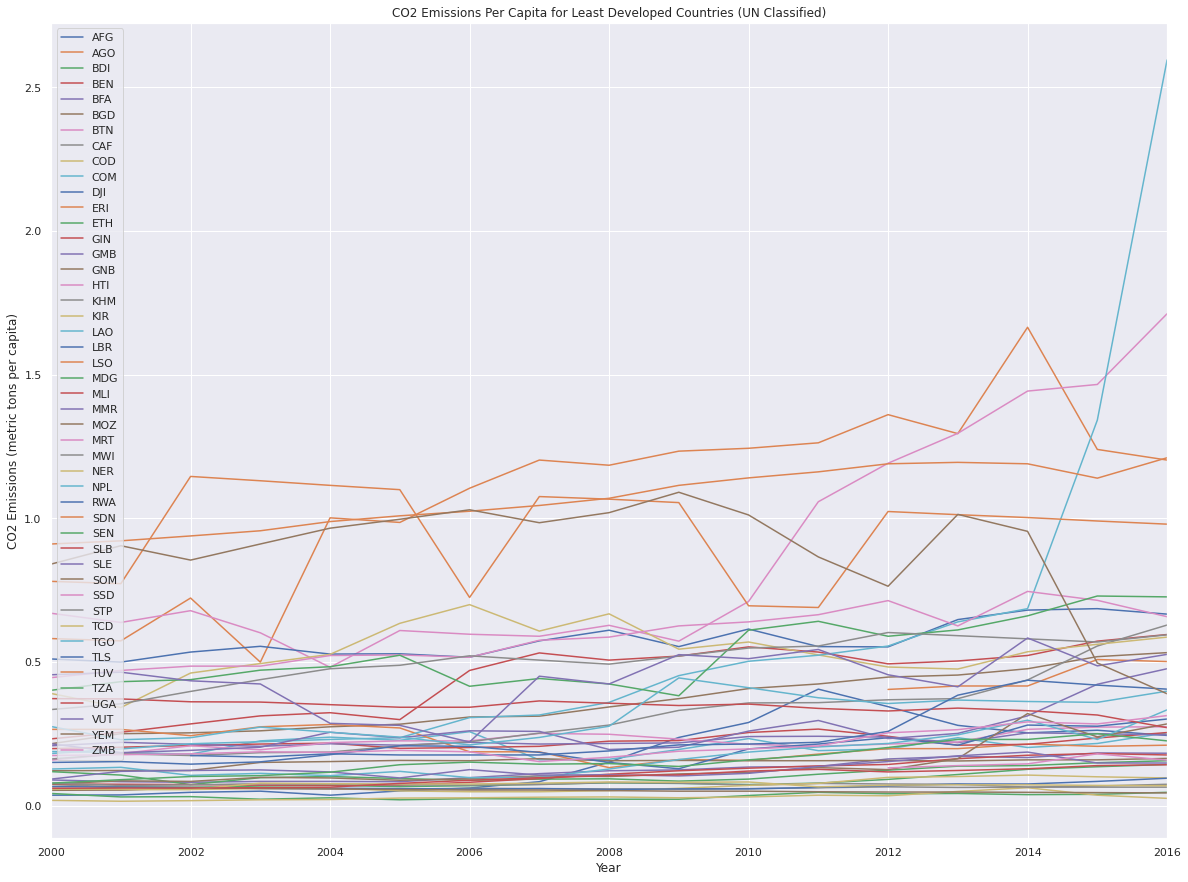

In [27]:
#Least Developed CO2
sn.set(rc={'figure.figsize':(20, 15)})
pivot_no_change_df = co2_emissions_df.melt(['Country Name', 'Country Code'], var_name='Year').rename(columns={'Country Code': 'Country_Code'})


plot_df = pivot_no_change_df.copy()
plot_df = pd.merge(left=least_developed_df, right=plot_df, left_on='Country Code', right_on='Country_Code', how='left')
plot_df

plot_df['Year'] = pd.to_datetime(plot_df['Year'], format='%Y')
plot_df.index = plot_df['Year']
plot_df.groupby('Country_Code')['value'].plot(legend=True)
plt.xlabel('Year')
plt.ylabel('CO2 Emissions (metric tons per capita)')
plt.title('CO2 Emissions Per Capita for Least Developed Countries (UN Classified)')
plt.show()

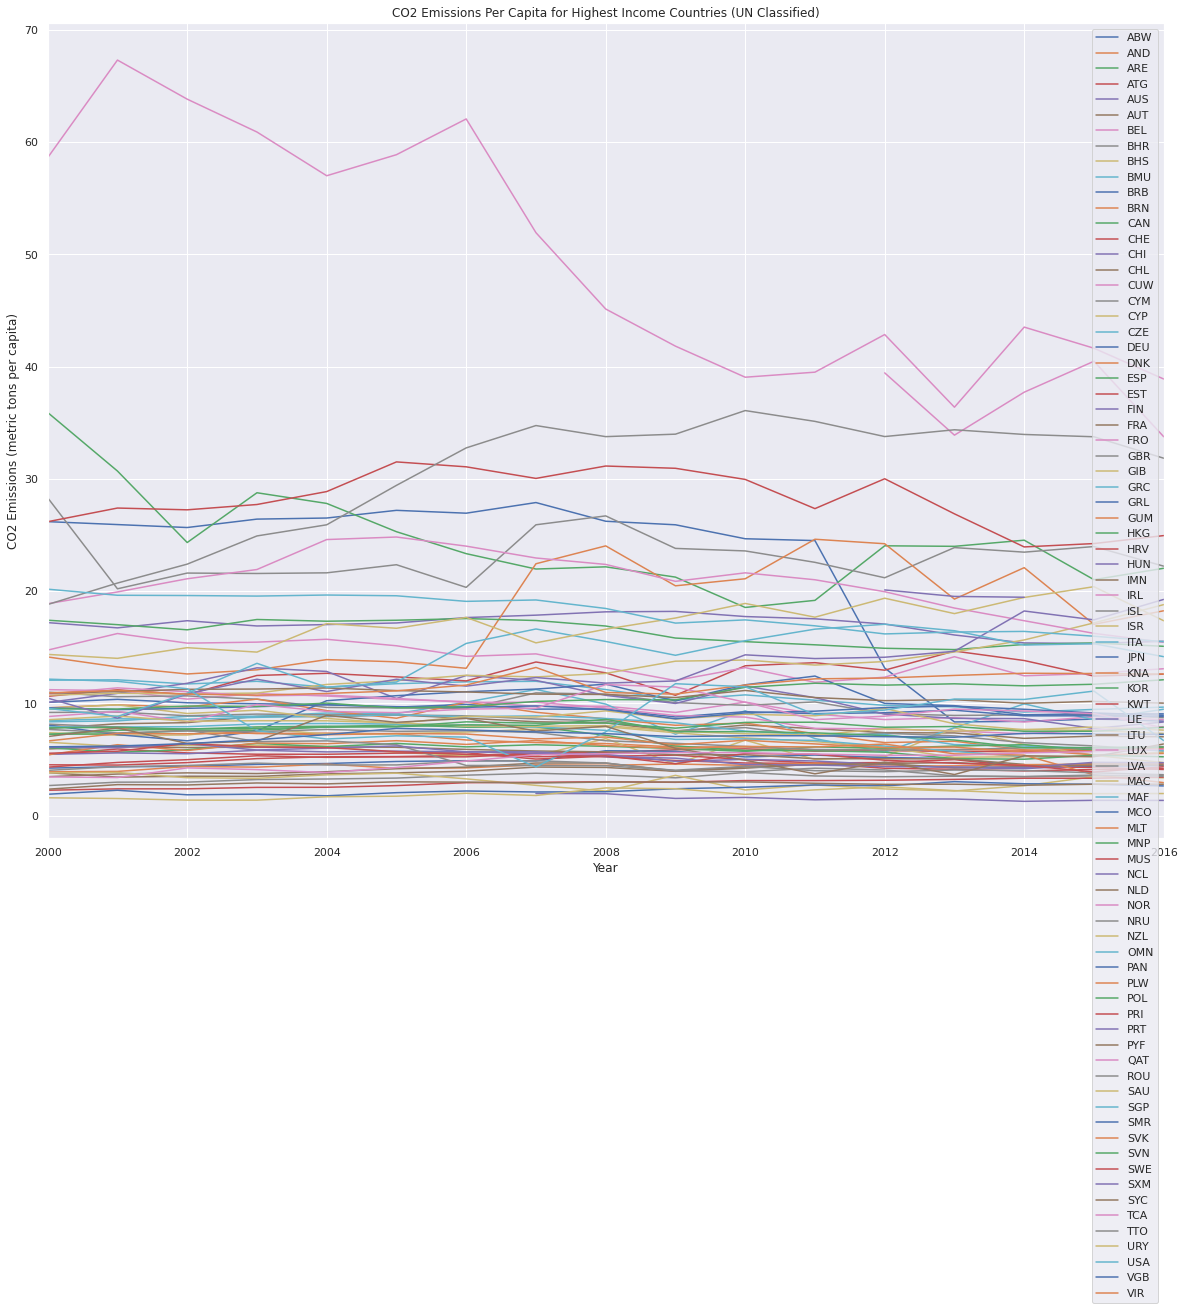

In [28]:
# Highest Income TB
sn.set(rc={'figure.figsize':(20, 15)})

plot_df2 = pivot_no_change_df.copy()
plot_df2 = pd.merge(left=high_income_df, right=plot_df2, left_on='Country Code', right_on='Country_Code', how='left')
plot_df2

plot_df2['Year'] = pd.to_datetime(plot_df2['Year'], format='%Y')
plot_df2.index = plot_df2['Year']
plot_df2.groupby('Country_Code')['value'].plot(legend=True)
plt.xlabel('Year')
plt.ylabel('CO2 Emissions (metric tons per capita)')
plt.title('CO2 Emissions Per Capita for Highest Income Countries (UN Classified)')
plt.show()

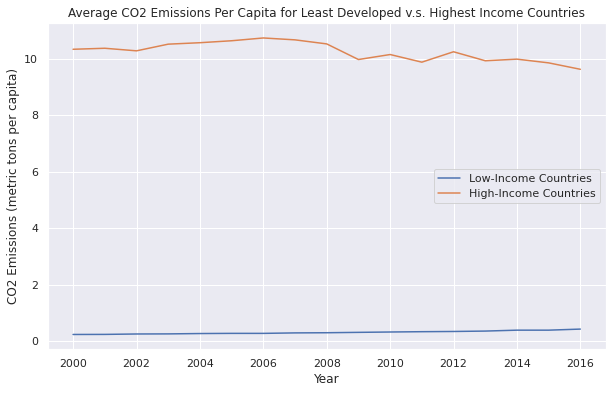

In [29]:
# Plotting Averages of the Two Country Groups Against One Another 
sn.set(rc={'figure.figsize':(10, 6)})
low_income_year_avg = plot_df.groupby(plot_df.index).mean()
high_income_year_avg = plot_df2.groupby(plot_df2.index).mean()
total_df = pd.merge(left=low_income_year_avg, right=high_income_year_avg, left_on=low_income_year_avg.index, right_on=high_income_year_avg.index, how='left').rename(columns={'key_0' : 'Year', 'value_x': 'Low-Income', 'value_y': 'High-Income'})


plt.plot(total_df['Year'], total_df['Low-Income'])
plt.plot(total_df['Year'], total_df['High-Income'])
plt.xlabel('Year')
plt.ylabel('CO2 Emissions (metric tons per capita)')
plt.title('Average CO2 Emissions Per Capita for Least Developed v.s. Highest Income Countries')
plt.legend(['Low-Income Countries','High-Income Countries'])
plt.show()


#### 2.1.2 Forest Area (Deforestation)

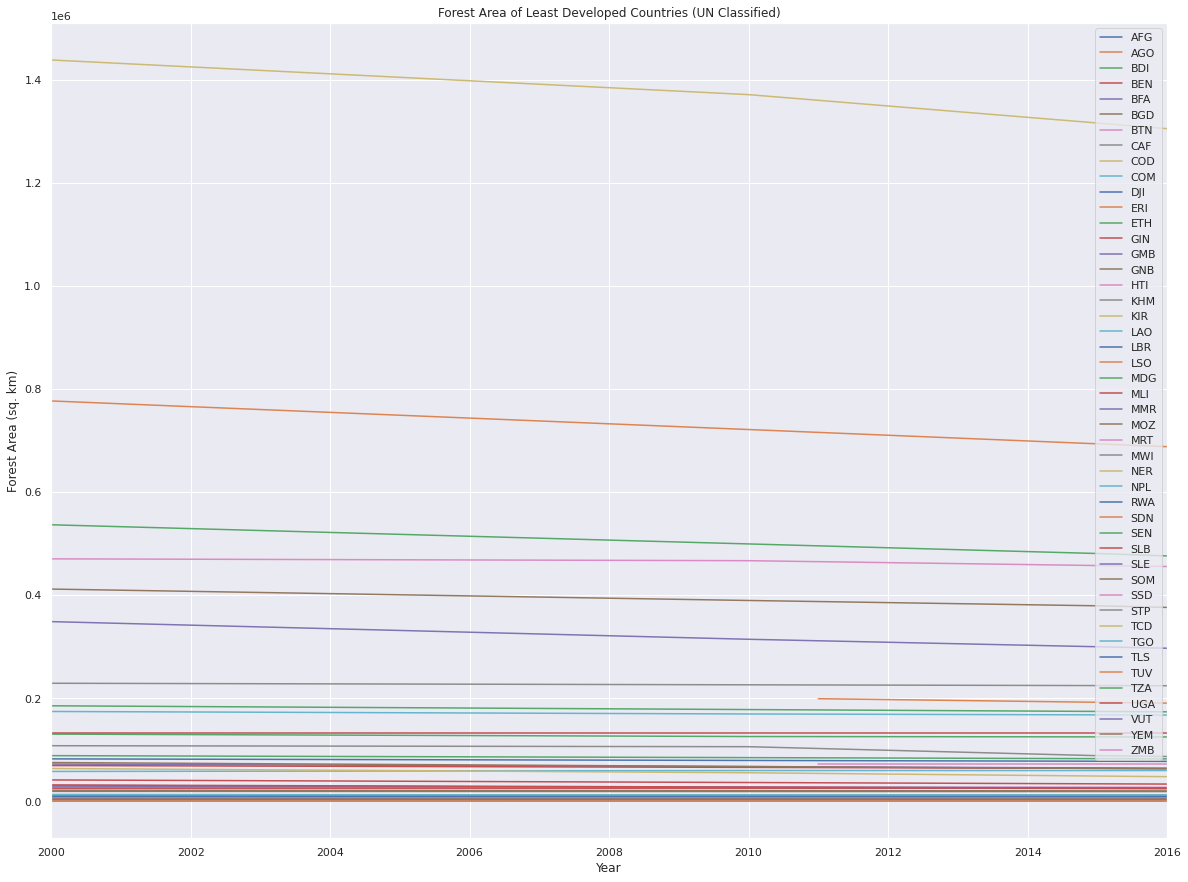

In [30]:
#Least Developed Forest Area
sn.set(rc={'figure.figsize':(20, 15)})
pivot_no_change_df = forest_area_df.melt(['Country Name', 'Country Code'], var_name='Year').rename(columns={'Country Code': 'Country_Code'})


plot_df = pivot_no_change_df.copy()
plot_df = pd.merge(left=least_developed_df, right=plot_df, left_on='Country Code', right_on='Country_Code', how='left')
plot_df

plot_df['Year'] = pd.to_datetime(plot_df['Year'], format='%Y')
plot_df.index = plot_df['Year']
plot_df.groupby('Country_Code')['value'].plot(legend=True)
plt.xlabel('Year')
plt.ylabel('Forest Area (sq. km)')
plt.title('Forest Area of Least Developed Countries (UN Classified)')
plt.show()

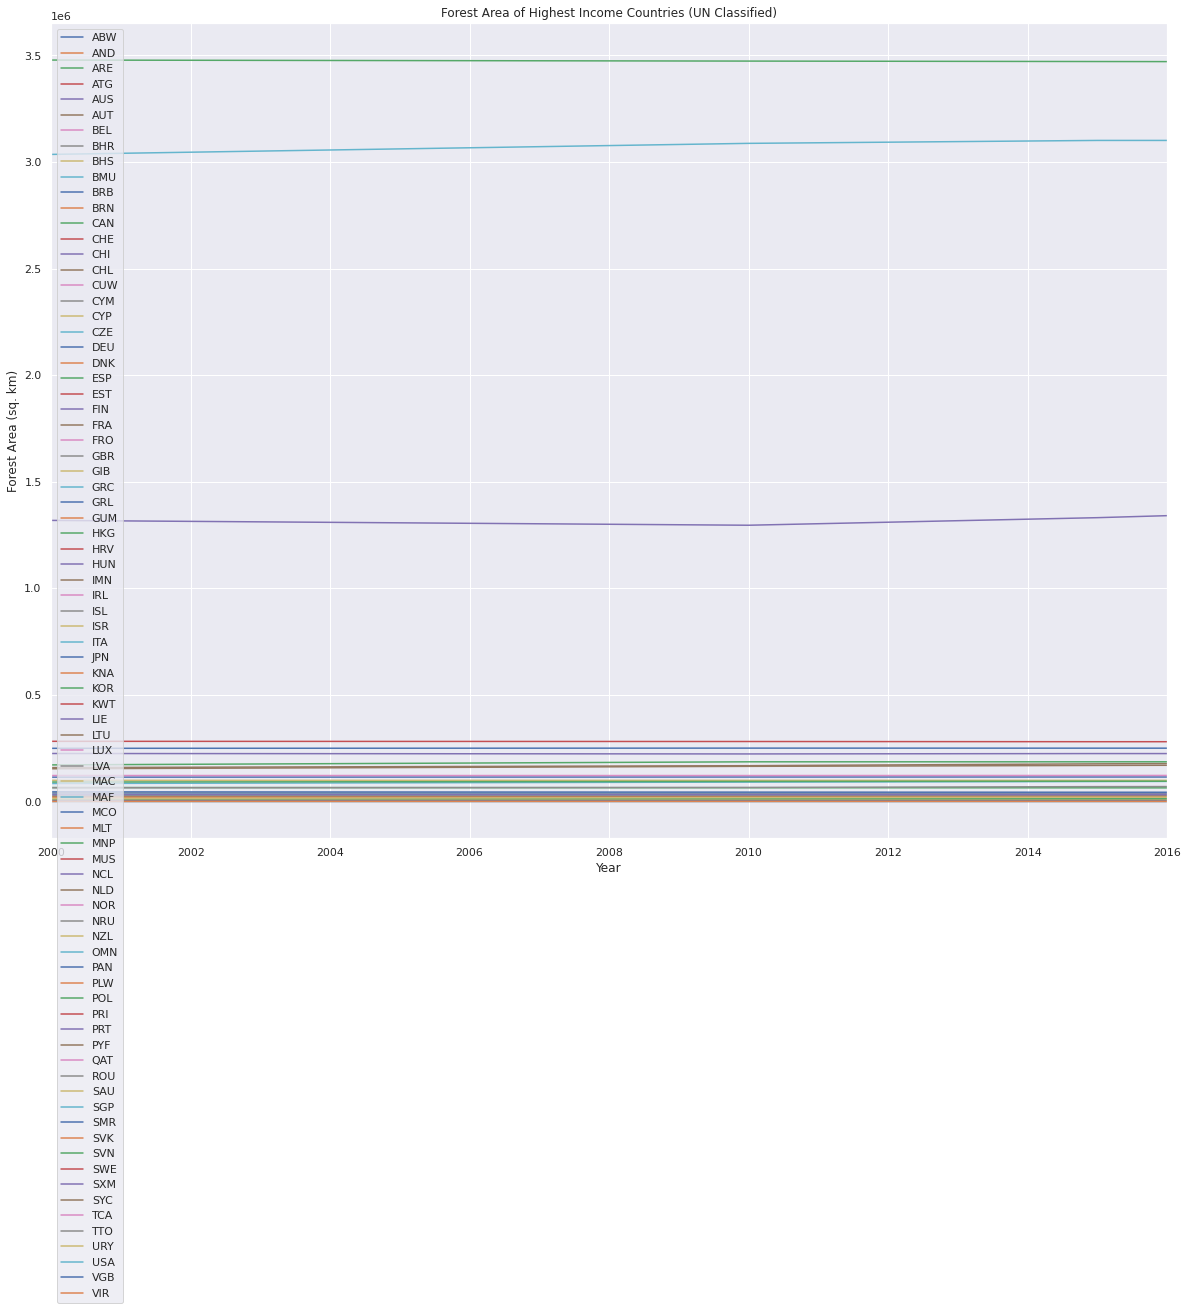

In [31]:
# Highest Income Forest Area
sn.set(rc={'figure.figsize':(20, 15)})

plot_df2 = pivot_no_change_df.copy()
plot_df2 = pd.merge(left=high_income_df, right=plot_df2, left_on='Country Code', right_on='Country_Code', how='left')
plot_df2

plot_df2['Year'] = pd.to_datetime(plot_df2['Year'], format='%Y')
plot_df2.index = plot_df2['Year']
plot_df2.groupby('Country_Code')['value'].plot(legend=True)
plt.xlabel('Year')
plt.ylabel('Forest Area (sq. km)')
plt.title('Forest Area of Highest Income Countries (UN Classified)')
plt.show()

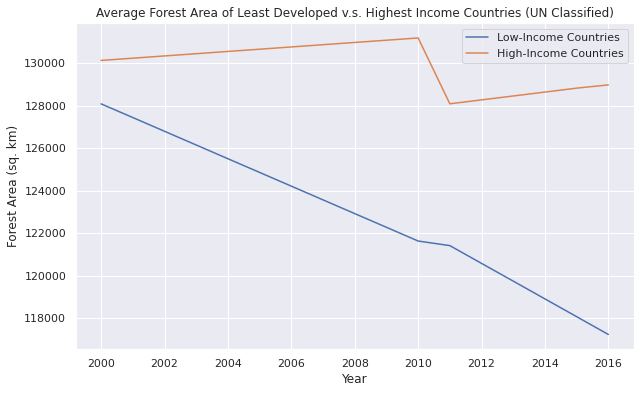

In [32]:
# Plotting Averages of the Two Country Groups Against One Another 
sn.set(rc={'figure.figsize':(10, 6)})
low_income_year_avg = plot_df.groupby(plot_df.index).mean()
high_income_year_avg = plot_df2.groupby(plot_df2.index).mean()
total_df = pd.merge(left=low_income_year_avg, right=high_income_year_avg, left_on=low_income_year_avg.index, right_on=high_income_year_avg.index, how='left').rename(columns={'key_0' : 'Year', 'value_x': 'Low-Income', 'value_y': 'High-Income'})


plt.plot(total_df['Year'], total_df['Low-Income'])
plt.plot(total_df['Year'], total_df['High-Income'])
plt.xlabel('Year')
plt.ylabel('Forest Area (sq. km)')
plt.title('Average Forest Area of Least Developed v.s. Highest Income Countries (UN Classified)')
plt.legend(['Low-Income Countries','High-Income Countries'])
plt.show()

#### 2.1.3 Urban Population Growth (Urban Sprawl)

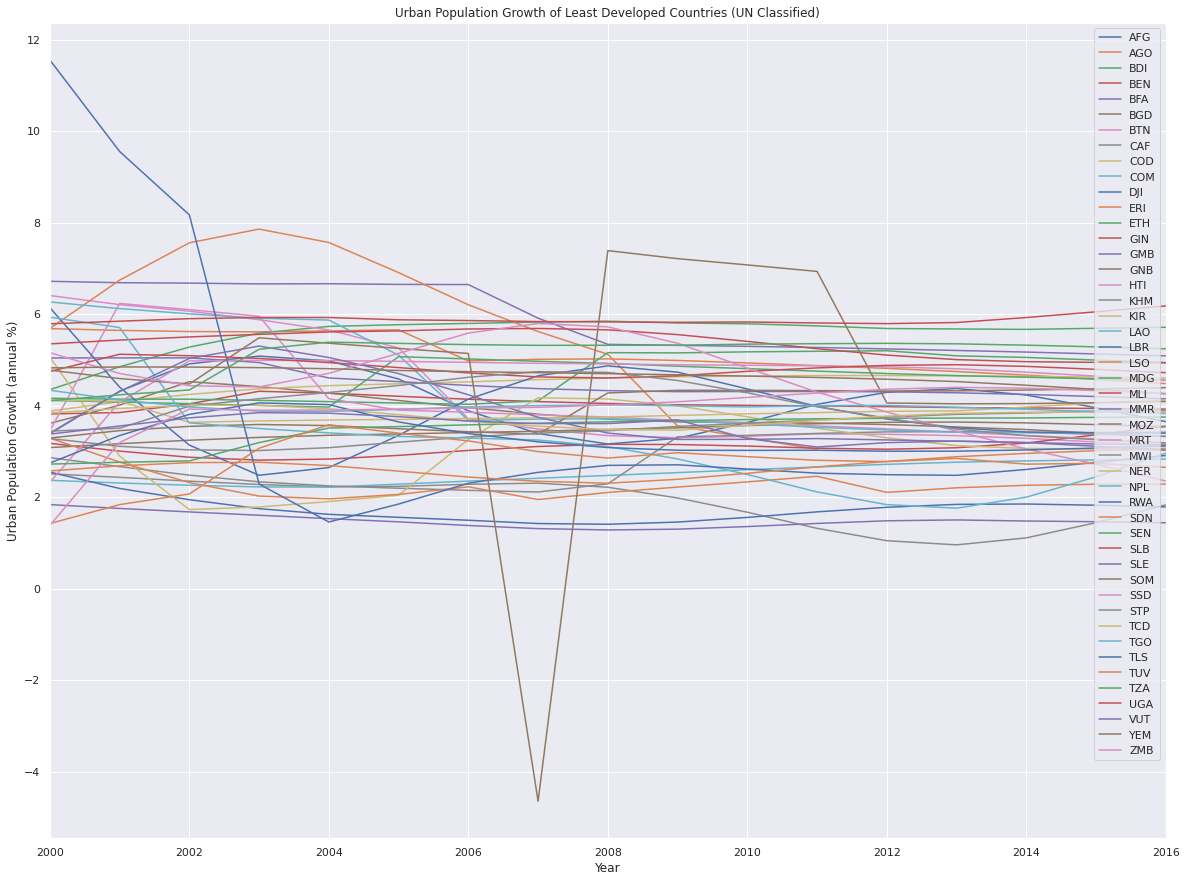

In [33]:
#Least Developed Urban Population Growth
sn.set(rc={'figure.figsize':(20, 15)})
pivot_no_change_df = urban_sprawl_df.melt(['Country Name', 'Country Code'], var_name='Year').rename(columns={'Country Code': 'Country_Code'})


plot_df = pivot_no_change_df.copy()
plot_df = pd.merge(left=least_developed_df, right=plot_df, left_on='Country Code', right_on='Country_Code', how='left')
plot_df

plot_df['Year'] = pd.to_datetime(plot_df['Year'], format='%Y')
plot_df.index = plot_df['Year']
plot_df.groupby('Country_Code')['value'].plot(legend=True)
plt.xlabel('Year')
plt.ylabel('Urban Population Growth (annual %)')
plt.title('Urban Population Growth of Least Developed Countries (UN Classified)')
plt.show()

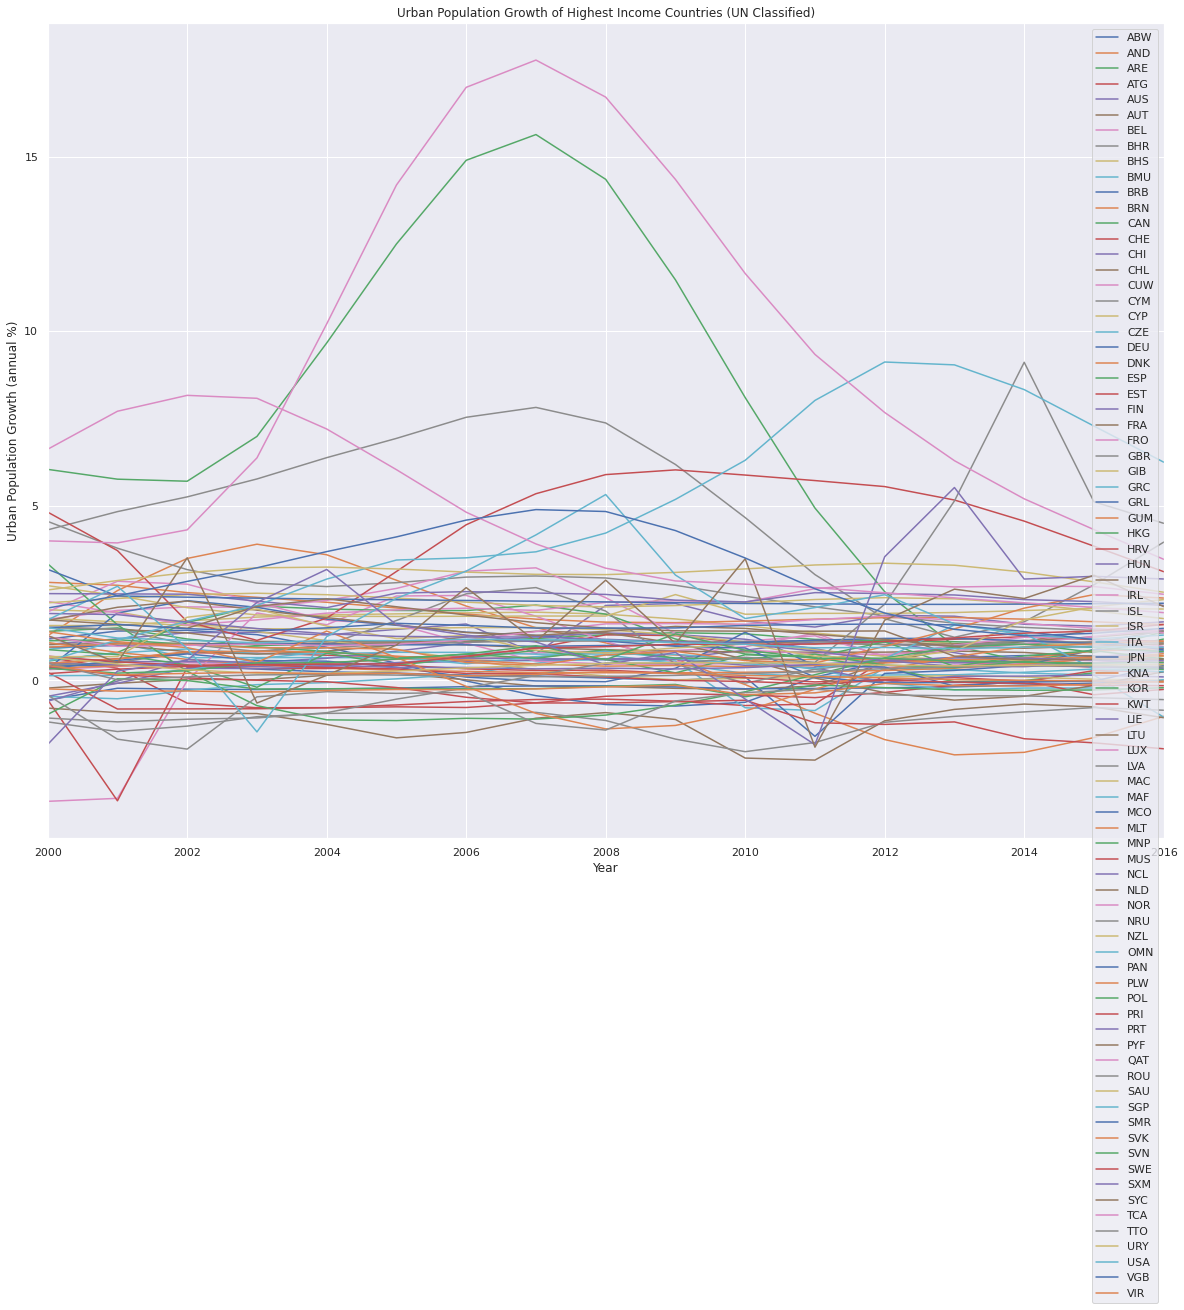

In [34]:
# Highest Income Urban Population Growth
sn.set(rc={'figure.figsize':(20, 15)})

plot_df2 = pivot_no_change_df.copy()
plot_df2 = pd.merge(left=high_income_df, right=plot_df2, left_on='Country Code', right_on='Country_Code', how='left')
plot_df2

plot_df2['Year'] = pd.to_datetime(plot_df2['Year'], format='%Y')
plot_df2.index = plot_df2['Year']
plot_df2.groupby('Country_Code')['value'].plot(legend=True)
plt.xlabel('Year')
plt.ylabel('Urban Population Growth (annual %)')
plt.title('Urban Population Growth of Highest Income Countries (UN Classified)')
plt.show()

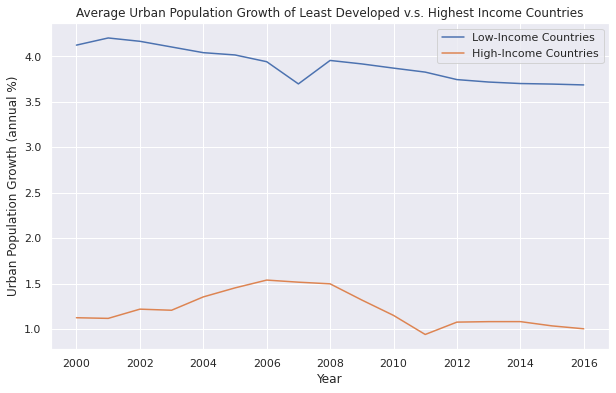

In [35]:
# Plotting Averages of the Two Country Groups Against One Another 
sn.set(rc={'figure.figsize':(10, 6)})
low_income_year_avg = plot_df.groupby(plot_df.index).mean()
high_income_year_avg = plot_df2.groupby(plot_df2.index).mean()
total_df = pd.merge(left=low_income_year_avg, right=high_income_year_avg, left_on=low_income_year_avg.index, right_on=high_income_year_avg.index, how='left').rename(columns={'key_0' : 'Year', 'value_x': 'Low-Income', 'value_y': 'High-Income'})


plt.plot(total_df['Year'], total_df['Low-Income'])
plt.plot(total_df['Year'], total_df['High-Income'])
plt.xlabel('Year')
plt.ylabel('Urban Population Growth (annual %)')
plt.title('Average Urban Population Growth of Least Developed v.s. Highest Income Countries')
plt.legend(['Low-Income Countries','High-Income Countries'])
plt.show()


It is very interesting to see that the largest producers of CO2 emissions aren't developing countries who tend to rely on cheaper fossil fuels but rather the most wealthy countries. Contextualizing CO2 emission data with the deforestation and urban growth data makes it evident that wealthier countries contribute the most to climate change, yet the least developed countries are the most vulnerable to climate change's ramifications. 

The least developed countries are experiencing a staggering and rapid rate of deforestation while it seems as if forest area for wealthy countries is staying stagnant, if not growing. Furthermore, the average urban growth rate of the least developed countries is almost triple that of the higher income countries, which will lead to the environmantal harms of urban sprawl. Overall, with the rapid rate of deforestation and the rapid rate of urban sprawl, the least developed countries are becoming more vulnerable to the harsh effects of climate change which are driven by the CO2 production of wealthier countries. These large inequities emphasize that these factors may have a large part with GDP growth and overall country development for the least developed countries.

### 2.2 EDA of Social Factors

#### 2.2.1 Percent of Salaried Workers 

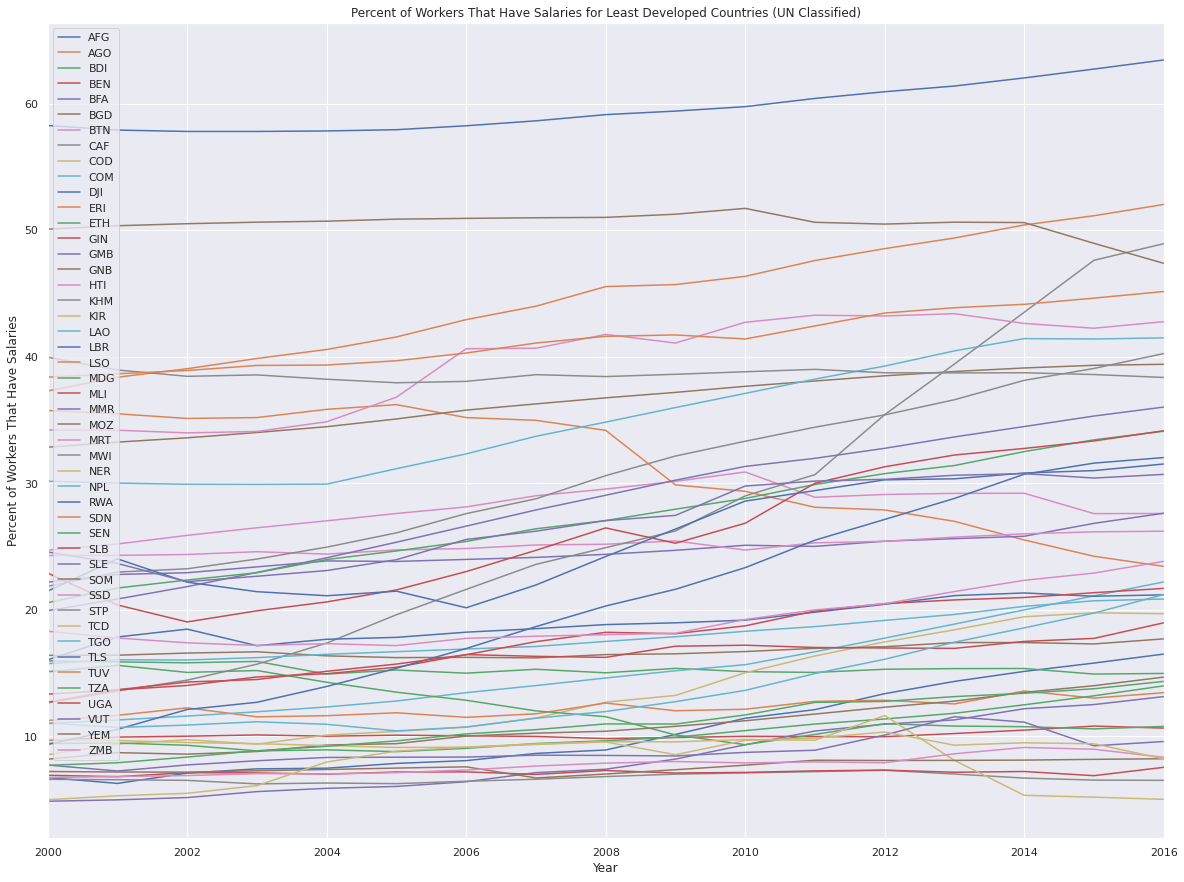

In [36]:
#Least Developed Salaried Workers
sn.set(rc={'figure.figsize':(20, 15)})
pivot_no_change_df = salaried_workers_df.melt(['Country Name', 'Country Code'], var_name='Year').rename(columns={'Country Code': 'Country_Code'})


plot_df = pivot_no_change_df.copy()
plot_df = pd.merge(left=least_developed_df, right=plot_df, left_on='Country Code', right_on='Country_Code', how='left')
plot_df

plot_df['Year'] = pd.to_datetime(plot_df['Year'], format='%Y')
plot_df.index = plot_df['Year']
plot_df.groupby('Country_Code')['value'].plot(legend=True)
plt.xlabel('Year')
plt.ylabel('Percent of Workers That Have Salaries')
plt.title('Percent of Workers That Have Salaries for Least Developed Countries (UN Classified)')
plt.show()

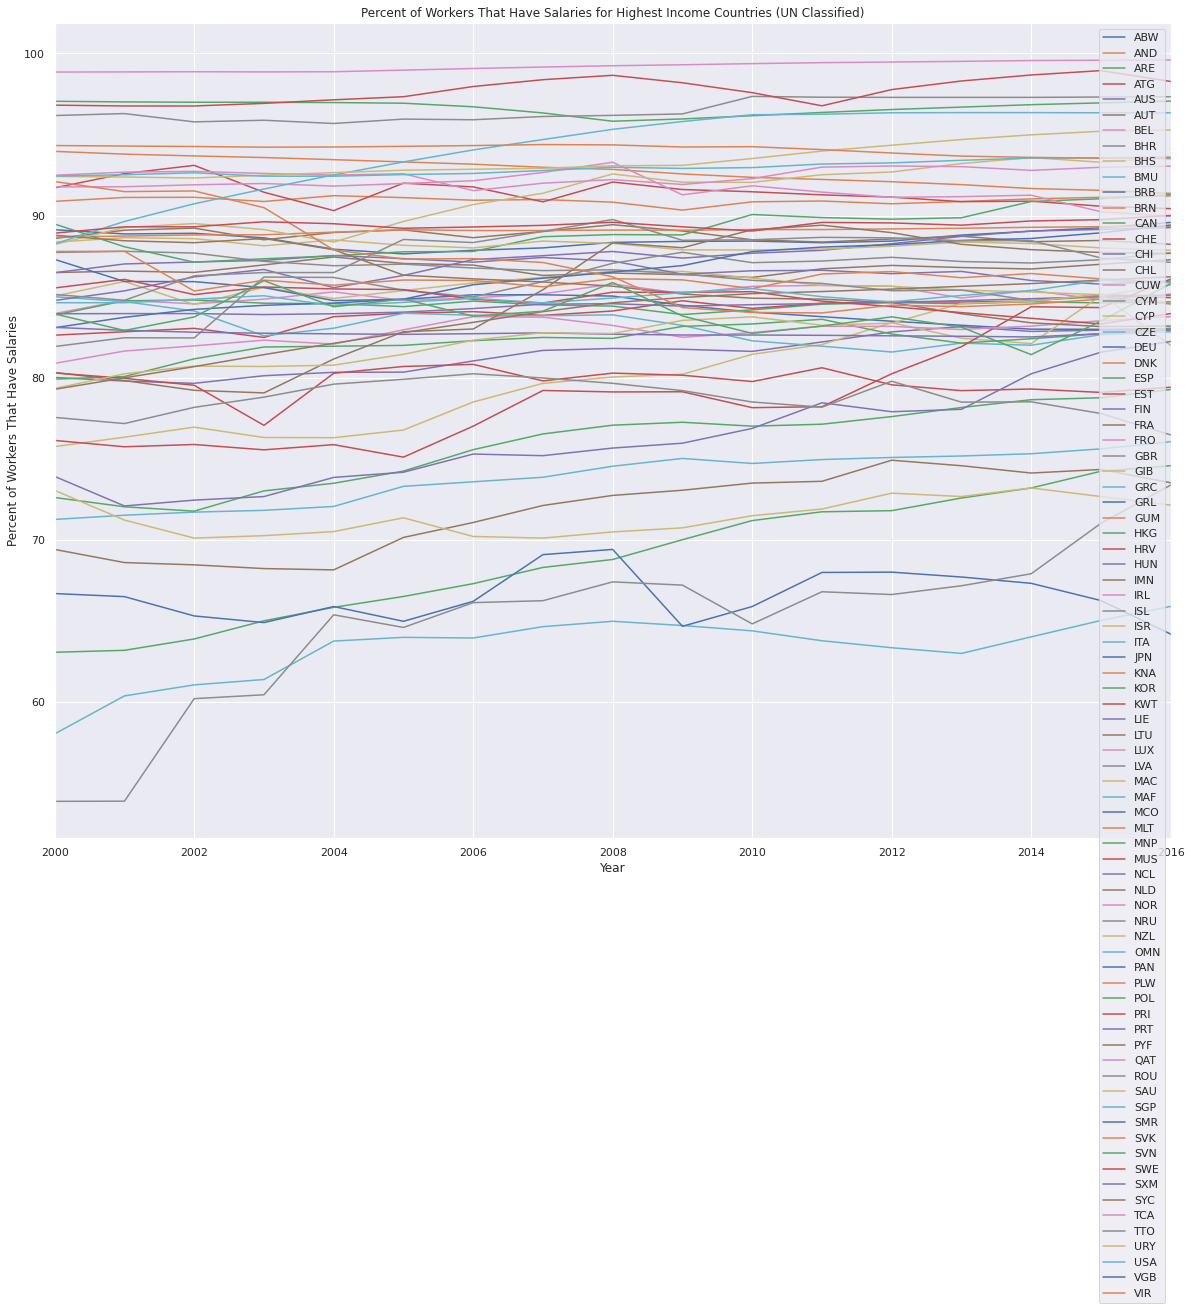

In [37]:
# Highest Income Salaried Workers
sn.set(rc={'figure.figsize':(20, 15)})

plot_df2 = pivot_no_change_df.copy()
plot_df2 = pd.merge(left=high_income_df, right=plot_df2, left_on='Country Code', right_on='Country_Code', how='left')
plot_df2

plot_df2['Year'] = pd.to_datetime(plot_df2['Year'], format='%Y')
plot_df2.index = plot_df2['Year']
plot_df2.groupby('Country_Code')['value'].plot(legend=True)
plt.xlabel('Year')
plt.ylabel('Percent of Workers That Have Salaries')
plt.title('Percent of Workers That Have Salaries for Highest Income Countries (UN Classified)')
plt.show()

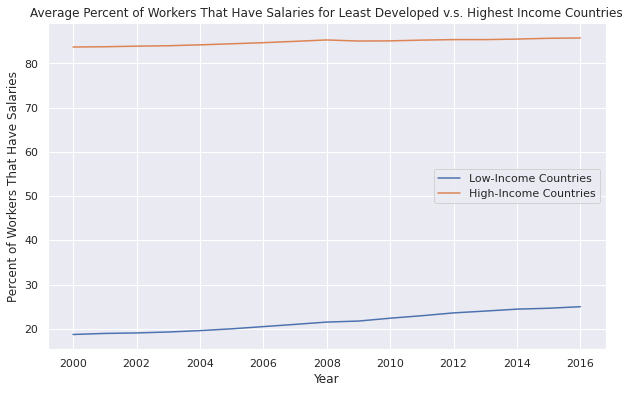

In [38]:
# Plotting Averages of the Two Country Groups Against One Another 
sn.set(rc={'figure.figsize':(10, 6)})
low_income_year_avg = plot_df.groupby(plot_df.index).mean()
high_income_year_avg = plot_df2.groupby(plot_df2.index).mean()
total_df = pd.merge(left=low_income_year_avg, right=high_income_year_avg, left_on=low_income_year_avg.index, right_on=high_income_year_avg.index, how='left').rename(columns={'key_0' : 'Year', 'value_x': 'Low-Income', 'value_y': 'High-Income'})


plt.plot(total_df['Year'], total_df['Low-Income'])
plt.plot(total_df['Year'], total_df['High-Income'])
plt.xlabel('Year')
plt.ylabel('Percent of Workers That Have Salaries')
plt.title('Average Percent of Workers That Have Salaries for Least Developed v.s. Highest Income Countries')
plt.legend(['Low-Income Countries','High-Income Countries'])
plt.show()

#### 2.2.2 Adoslescent Fertility

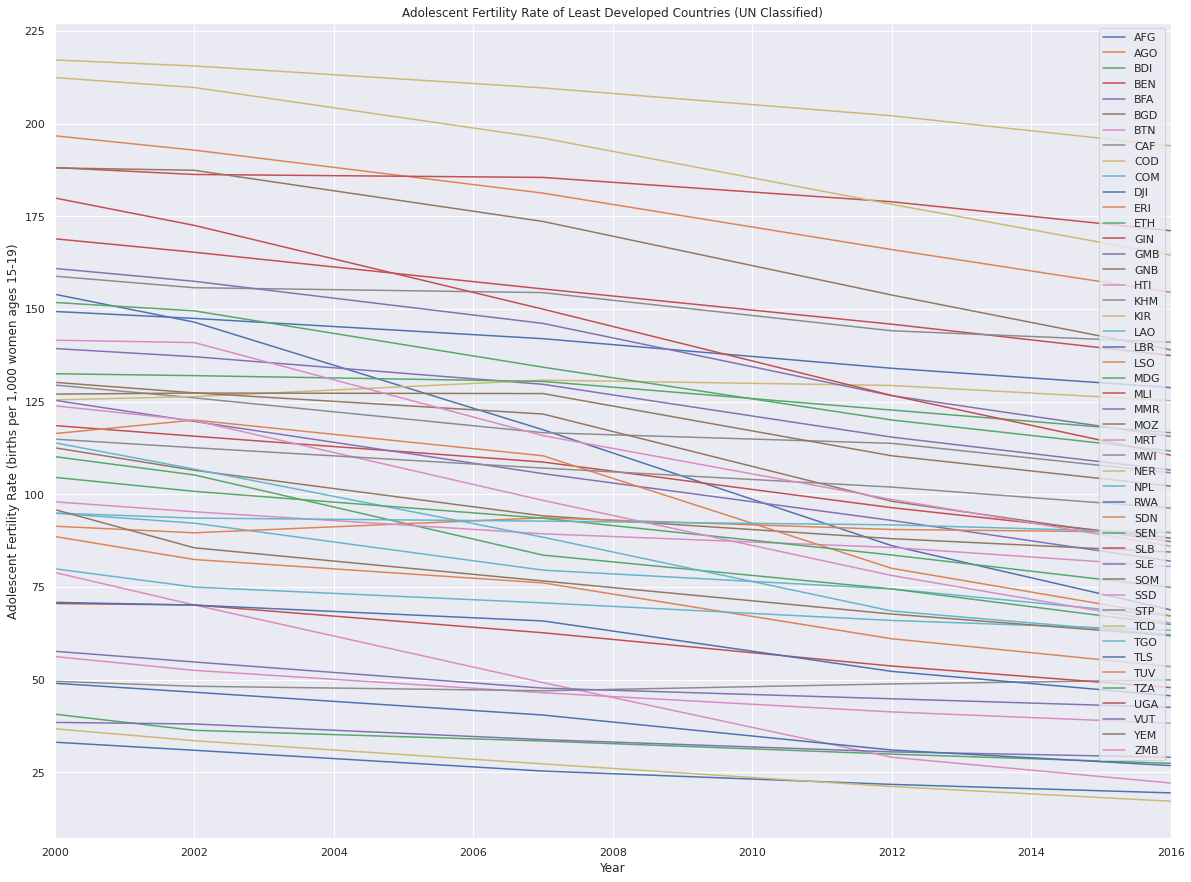

In [39]:
#Least Developed Adolescent Fertility Rate (births per 1,000 women ages 15-19)
sn.set(rc={'figure.figsize':(20, 15)})
pivot_no_change_df = adolescent_fertility_df.melt(['Country Name', 'Country Code'], var_name='Year').rename(columns={'Country Code': 'Country_Code'})


plot_df = pivot_no_change_df.copy()
plot_df = pd.merge(left=least_developed_df, right=plot_df, left_on='Country Code', right_on='Country_Code', how='left')
plot_df

plot_df['Year'] = pd.to_datetime(plot_df['Year'], format='%Y')
plot_df.index = plot_df['Year']
plot_df.groupby('Country_Code')['value'].plot(legend=True)
plt.xlabel('Year')
plt.ylabel('Adolescent Fertility Rate (births per 1,000 women ages 15-19)')
plt.title('Adolescent Fertility Rate of Least Developed Countries (UN Classified)')
plt.show()

#Adolescent fertility rate (births per 1,000 women ages 15-19)


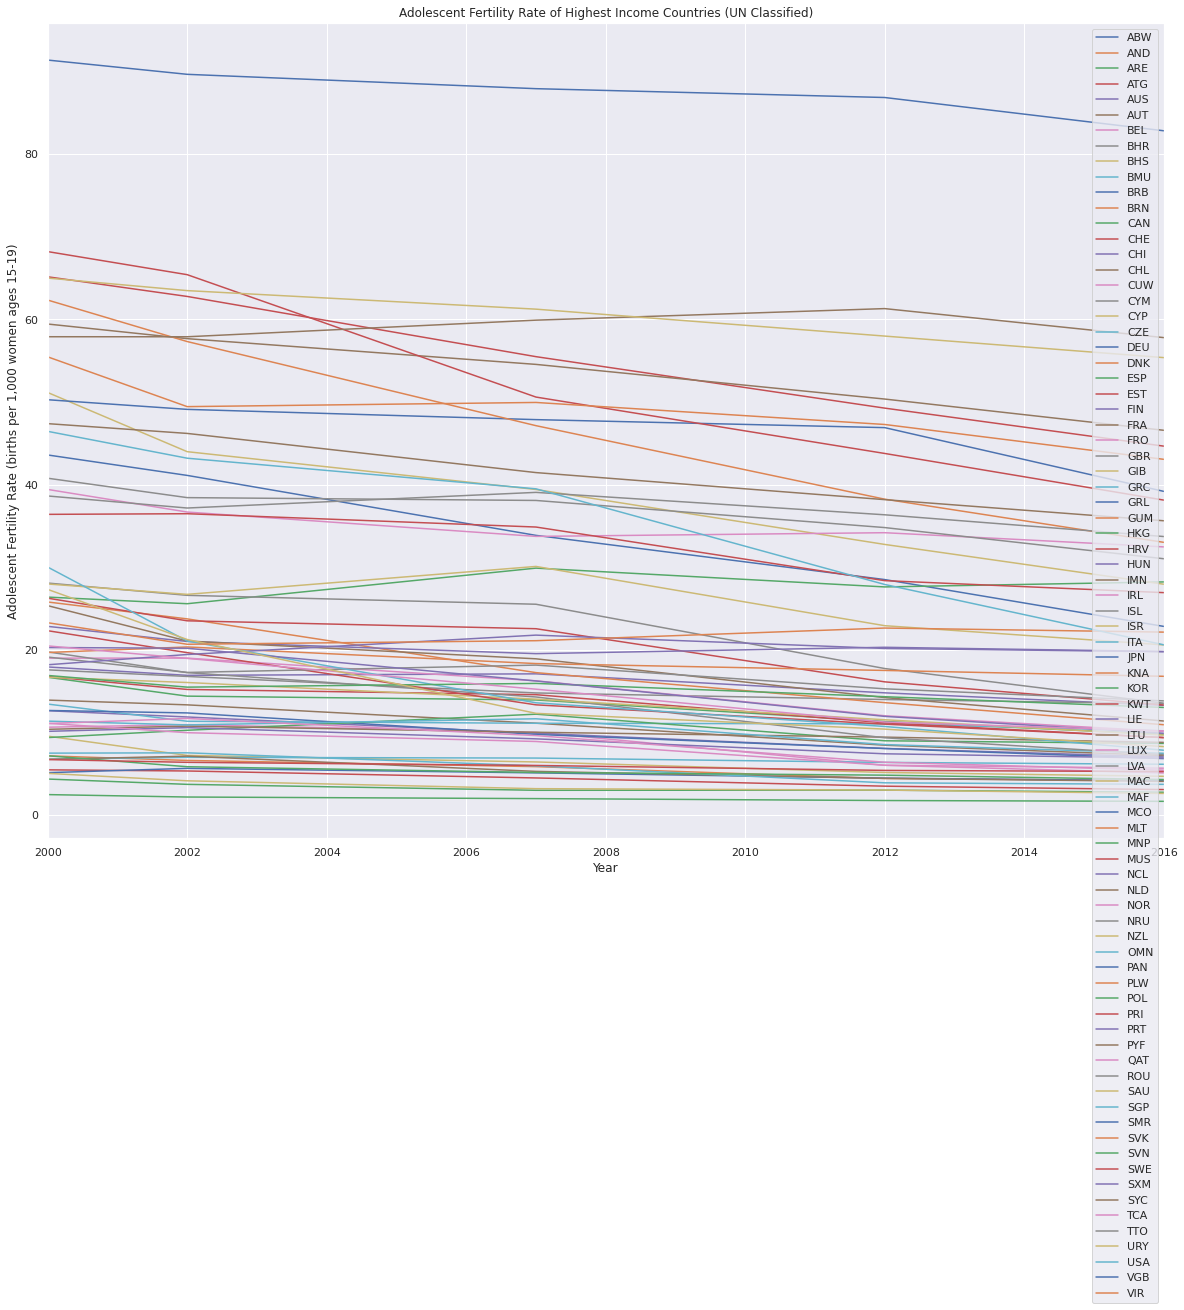

In [40]:
# Highest Income Adolescent Fertility Rate (births per 1,000 women ages 15-19)
sn.set(rc={'figure.figsize':(20, 15)})

plot_df2 = pivot_no_change_df.copy()
plot_df2 = pd.merge(left=high_income_df, right=plot_df2, left_on='Country Code', right_on='Country_Code', how='left')
plot_df2

plot_df2['Year'] = pd.to_datetime(plot_df2['Year'], format='%Y')
plot_df2.index = plot_df2['Year']
plot_df2.groupby('Country_Code')['value'].plot(legend=True)
plt.xlabel('Year')
plt.ylabel('Adolescent Fertility Rate (births per 1,000 women ages 15-19)')
plt.title('Adolescent Fertility Rate of Highest Income Countries (UN Classified)')
plt.show()

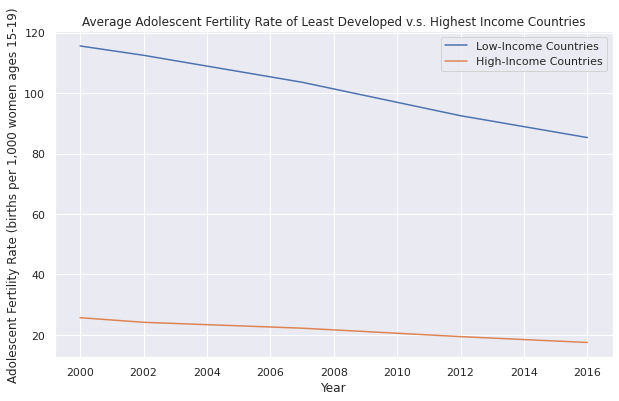

In [41]:
# Plotting Averages of the Two Country Groups Against One Another 
sn.set(rc={'figure.figsize':(10, 6)})
low_income_year_avg = plot_df.groupby(plot_df.index).mean()
high_income_year_avg = plot_df2.groupby(plot_df2.index).mean()
total_df = pd.merge(left=low_income_year_avg, right=high_income_year_avg, left_on=low_income_year_avg.index, right_on=high_income_year_avg.index, how='left').rename(columns={'key_0' : 'Year', 'value_x': 'Low-Income', 'value_y': 'High-Income'})


plt.plot(total_df['Year'], total_df['Low-Income'])
plt.plot(total_df['Year'], total_df['High-Income'])
plt.xlabel('Year')
plt.ylabel('Adolescent Fertility Rate (births per 1,000 women ages 15-19)')
plt.title('Average Adolescent Fertility Rate of Least Developed v.s. Highest Income Countries')
plt.legend(['Low-Income Countries','High-Income Countries'])
plt.show()

#### 2.2.3 Age Dependency Ratio

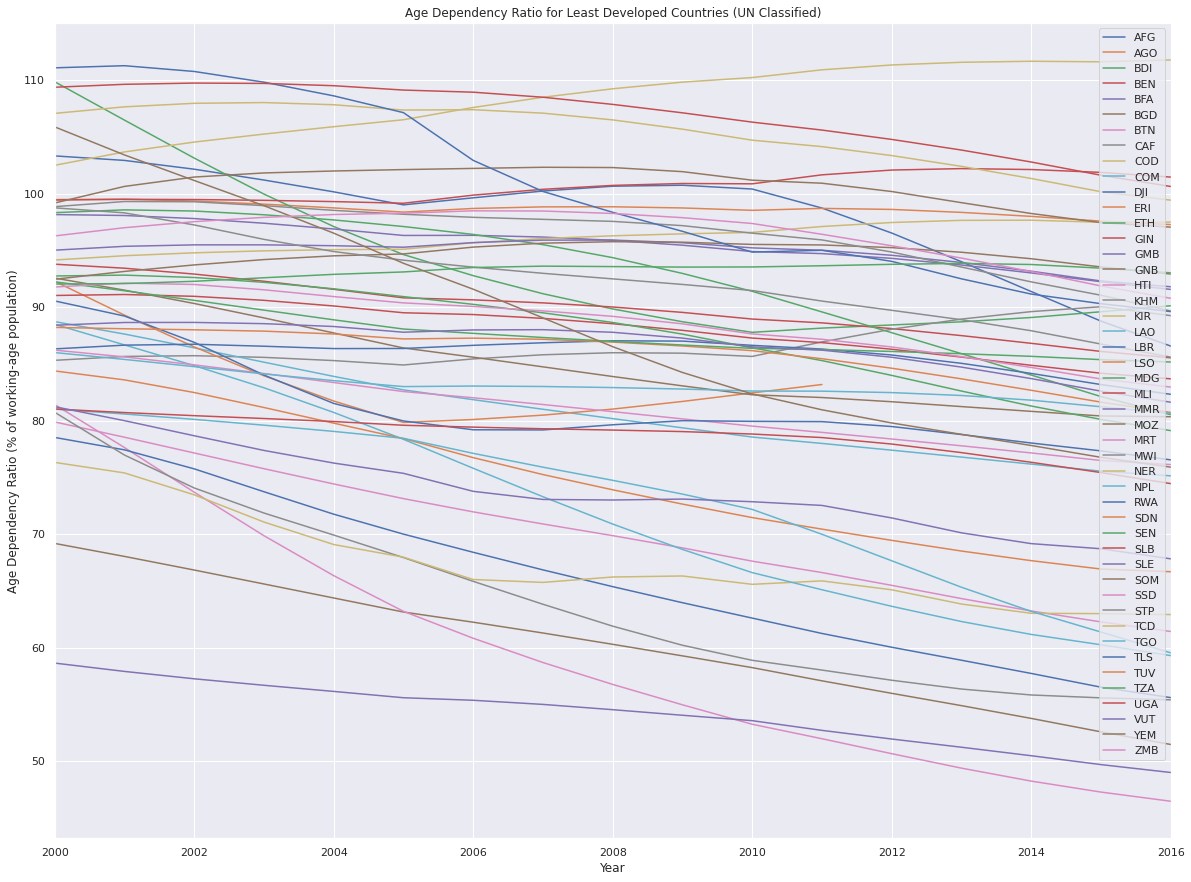

In [42]:
#Least Developed Age Dependency Ratio
sn.set(rc={'figure.figsize':(20, 15)})
pivot_no_change_df = age_dependency_df.melt(['Country Name', 'Country Code'], var_name='Year').rename(columns={'Country Code': 'Country_Code'})


plot_df = pivot_no_change_df.copy()
plot_df = pd.merge(left=least_developed_df, right=plot_df, left_on='Country Code', right_on='Country_Code', how='left')
plot_df

plot_df['Year'] = pd.to_datetime(plot_df['Year'], format='%Y')
plot_df.index = plot_df['Year']
plot_df.groupby('Country_Code')['value'].plot(legend=True)
plt.xlabel('Year')
plt.ylabel('Age Dependency Ratio (% of working-age population)')
plt.title('Age Dependency Ratio for Least Developed Countries (UN Classified)')
plt.show()


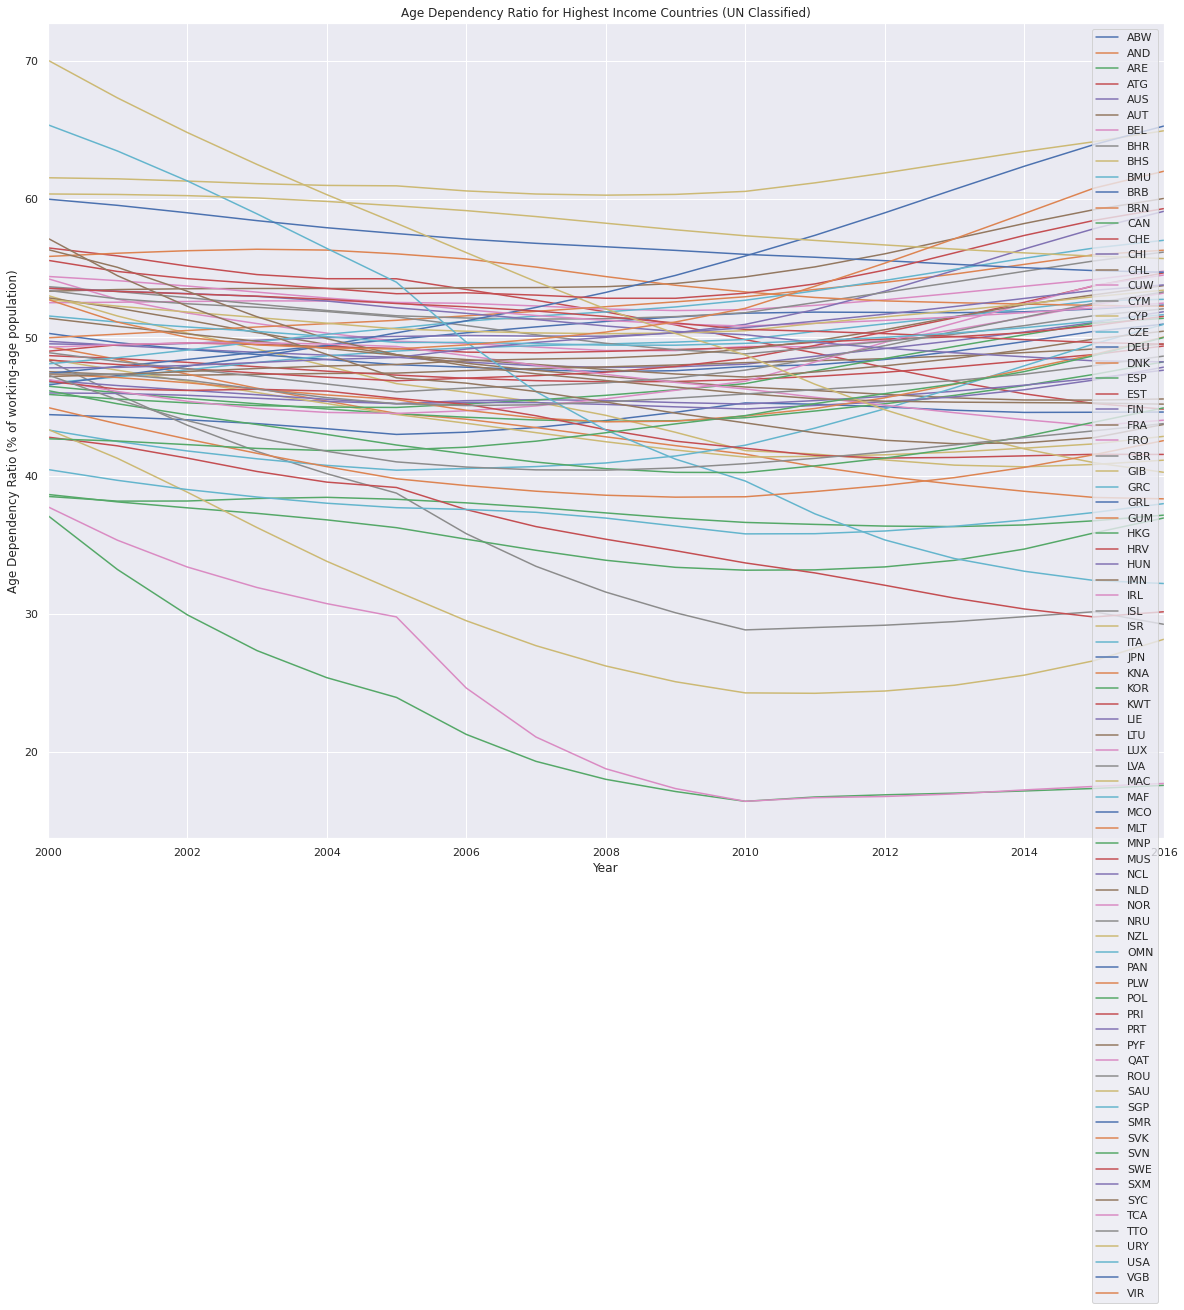

In [43]:
# Highest Income Age Dependency Ratio
sn.set(rc={'figure.figsize':(20, 15)})

plot_df2 = pivot_no_change_df.copy()
plot_df2 = pd.merge(left=high_income_df, right=plot_df2, left_on='Country Code', right_on='Country_Code', how='left')
plot_df2

plot_df2['Year'] = pd.to_datetime(plot_df2['Year'], format='%Y')
plot_df2.index = plot_df2['Year']
plot_df2.groupby('Country_Code')['value'].plot(legend=True)
plt.xlabel('Year')
plt.ylabel('Age Dependency Ratio (% of working-age population)')
plt.title('Age Dependency Ratio for Highest Income Countries (UN Classified)')
plt.show()

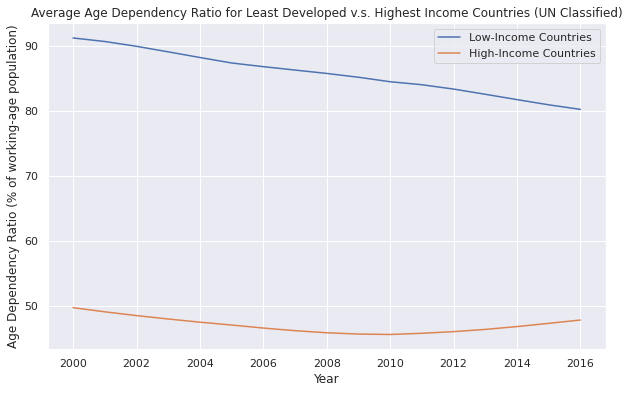

In [44]:
# Plotting Averages of the Two Country Groups Against One Another 
sn.set(rc={'figure.figsize':(10, 6)})
low_income_year_avg = plot_df.groupby(plot_df.index).mean()
high_income_year_avg = plot_df2.groupby(plot_df2.index).mean()
total_df = pd.merge(left=low_income_year_avg, right=high_income_year_avg, left_on=low_income_year_avg.index, right_on=high_income_year_avg.index, how='left').rename(columns={'key_0' : 'Year', 'value_x': 'Low-Income', 'value_y': 'High-Income'})


plt.plot(total_df['Year'], total_df['Low-Income'])
plt.plot(total_df['Year'], total_df['High-Income'])
plt.xlabel('Year')
plt.ylabel('Age Dependency Ratio (% of working-age population)')
plt.title('Average Age Dependency Ratio for Least Developed v.s. Highest Income Countries (UN Classified)')
plt.legend(['Low-Income Countries','High-Income Countries'])
plt.show()

The large inequity between these social factors is stark. The average percent of workers with a salary in the least developed countries didn't rise above 30% by 2016 while the highest income countries had over 80% for the entire time frame. Furthermore, the individual countries themselves for the least developed group saw more variablity in their percent salaried compared to the highest income, indicating inadequate employment regulations and the lack of highly developed service industries - we may see more farming for example, which in many countries don't see salaries.

The adolescent fertility rate and the age dependency may present some correlation, since a greater age dependency rate (meaning more children to workers) would inherently increase the adolescent fertility rate and this will be explored later to look for correlation. However, average adolescent fertility rate was almost 4 times larger for low income countries than high income countries by 2016, which isn't explained by the disparity in average age dependency ratio, which is less than twice of that for low income versus high income countries in 2016. 

These factors indicate that the social context of a country witnesses immense disparities between the most and least devleoped countries and are apt factors to include in our model. 

### 2.3 EDA of Health and Disease Factors

#### 2.3.1 Tuberculosis

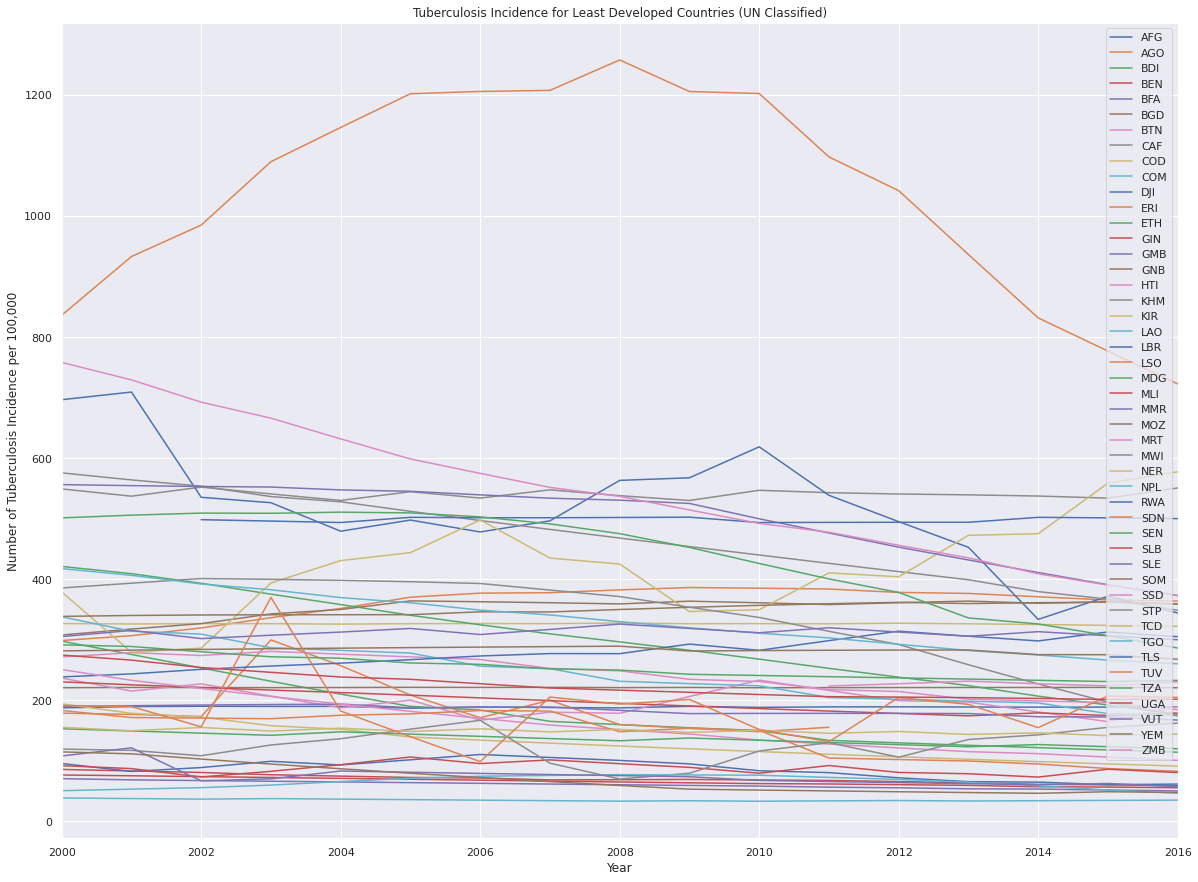

In [45]:
#Least Developed TB
sn.set(rc={'figure.figsize':(20, 15)})
tb_pivot_no_change_df = tb_df.melt(['Country', 'Country Code'], var_name='Year').rename(columns={'Country Code': 'Country_Code'})


tb_plot_df = tb_pivot_no_change_df.copy()
tb_plot_df = pd.merge(left=least_developed_df, right=tb_plot_df, left_on='Country Code', right_on='Country_Code', how='left')
tb_plot_df

tb_plot_df['Year'] = pd.to_datetime(tb_plot_df['Year'], format='%Y')
tb_plot_df.index = tb_plot_df['Year']
tb_plot_df.groupby('Country_Code')['value'].plot(legend=True)
plt.xlabel('Year')
plt.ylabel('Number of Tuberculosis Incidence per 100,000')
plt.title('Tuberculosis Incidence for Least Developed Countries (UN Classified)')
plt.show()

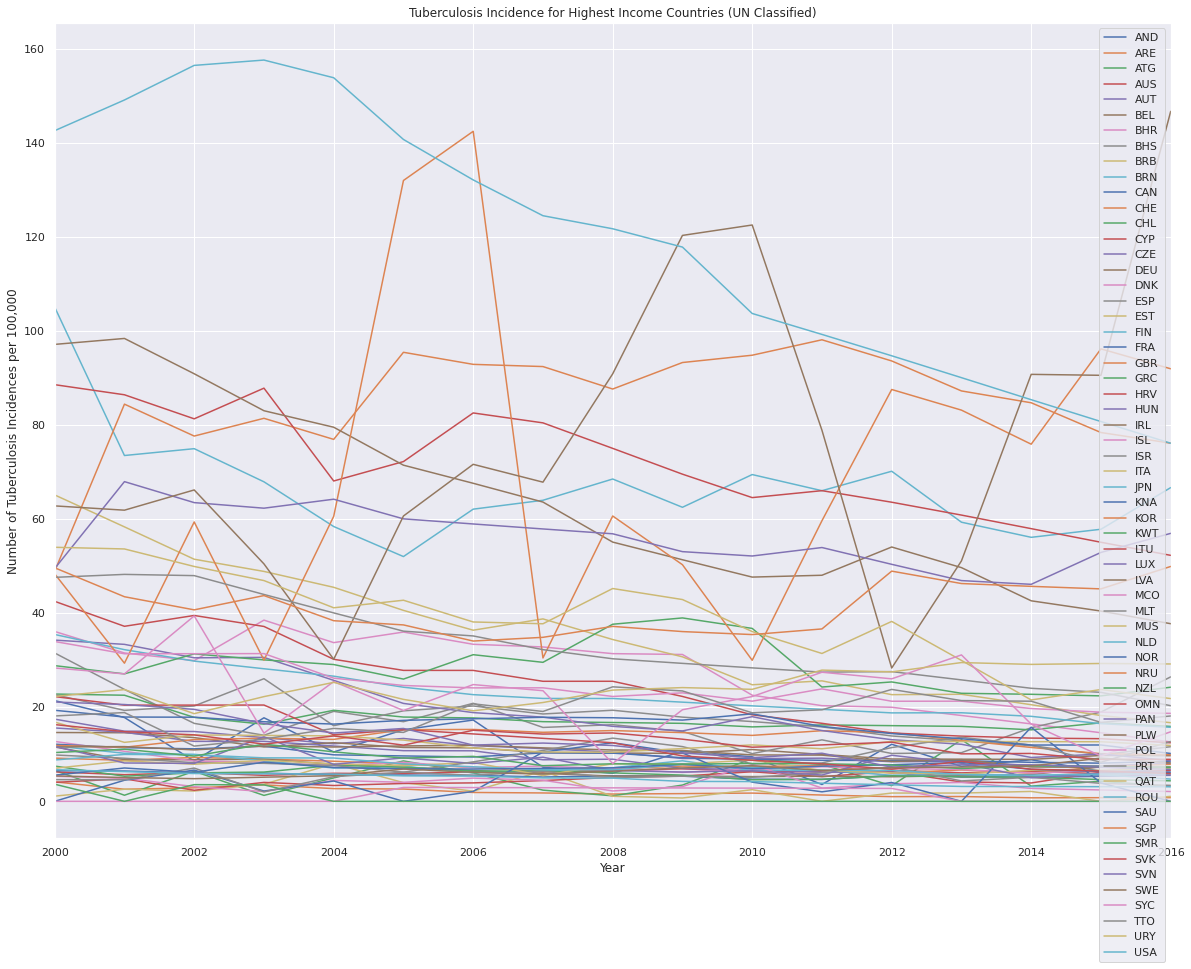

In [46]:
# Highest Income TB
sn.set(rc={'figure.figsize':(20, 15)})

tb_plot_df2 = tb_pivot_no_change_df.copy()
tb_plot_df2 = pd.merge(left=high_income_df, right=tb_plot_df2, left_on='Country Code', right_on='Country_Code', how='left')
tb_plot_df2

tb_plot_df2['Year'] = pd.to_datetime(tb_plot_df2['Year'], format='%Y')
tb_plot_df2.index = tb_plot_df2['Year']
tb_plot_df2.groupby('Country_Code')['value'].plot(legend=True)
plt.xlabel('Year')
plt.ylabel('Number of Tuberculosis Incidences per 100,000')
plt.title('Tuberculosis Incidence for Highest Income Countries (UN Classified)')
plt.show()

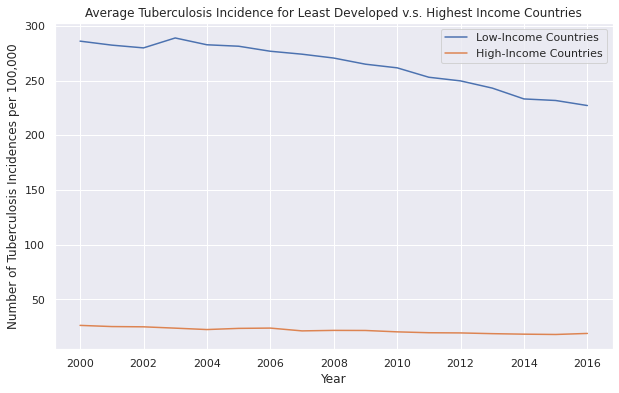

In [47]:
# Plotting Averages of the Two Country Groups Against One Another 
sn.set(rc={'figure.figsize':(10, 6)})
tb_low_income_year_avg = tb_plot_df.groupby(tb_plot_df.index).mean()
tb_high_income_year_avg = tb_plot_df2.groupby(tb_plot_df2.index).mean()
total_df = pd.merge(left=tb_low_income_year_avg, right=tb_high_income_year_avg, left_on=tb_low_income_year_avg.index, right_on=tb_high_income_year_avg.index, how='left').rename(columns={'key_0' : 'Year', 'value_x': 'Low-Income', 'value_y': 'High-Income'})


plt.plot(total_df['Year'], total_df['Low-Income'])
plt.plot(total_df['Year'], total_df['High-Income'])
plt.title('Average Tuberculosis Incidence for Least Developed v.s. Highest Income Countries')
plt.xlabel('Year')
plt.ylabel('Number of Tuberculosis Incidences per 100,000')
plt.legend(['Low-Income Countries','High-Income Countries'])
plt.show()

#### 2.3.2 Healthcare Expenditures

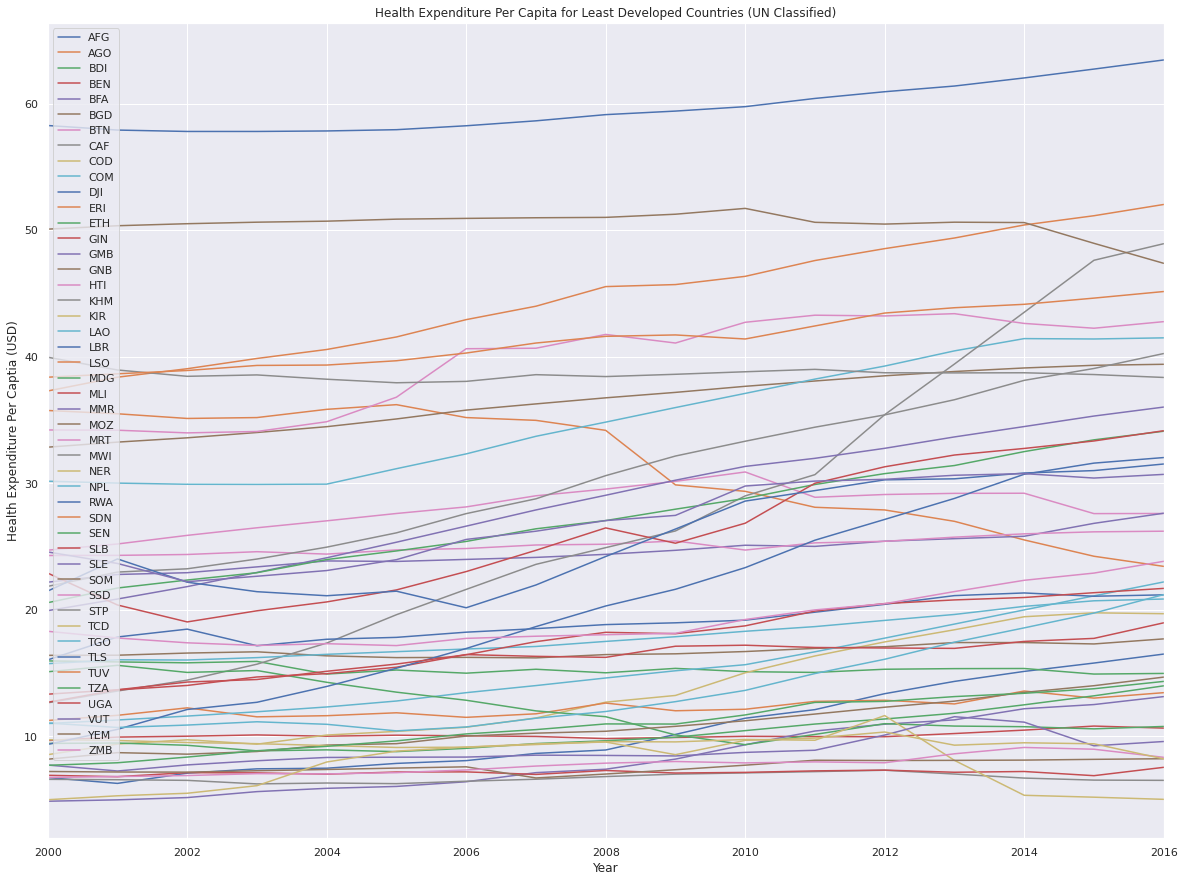

In [48]:
#Least Developed Healthcare Expenditures
sn.set(rc={'figure.figsize':(20, 15)})
healthcare_ex_pivot_no_change_df = health_expenditures_df.melt(['Country Name', 'Country Code'], var_name='Year').rename(columns={'Country Code': 'Country_Code'})


healthcare_ex_plot_df = healthcare_ex_pivot_no_change_df.copy()
healthcare_ex_plot_df = pd.merge(left=least_developed_df, right=healthcare_ex_plot_df, left_on='Country Code', right_on='Country_Code', how='left')
healthcare_ex_plot_df

healthcare_ex_plot_df['Year'] = pd.to_datetime(healthcare_ex_plot_df['Year'], format='%Y')
healthcare_ex_plot_df.index = healthcare_ex_plot_df['Year']
healthcare_ex_plot_df.groupby('Country_Code')['value'].plot(legend=True)
plt.xlabel('Year')
plt.ylabel('Health Expenditure Per Captia (USD)')
plt.title('Health Expenditure Per Capita for Least Developed Countries (UN Classified)')
plt.show()

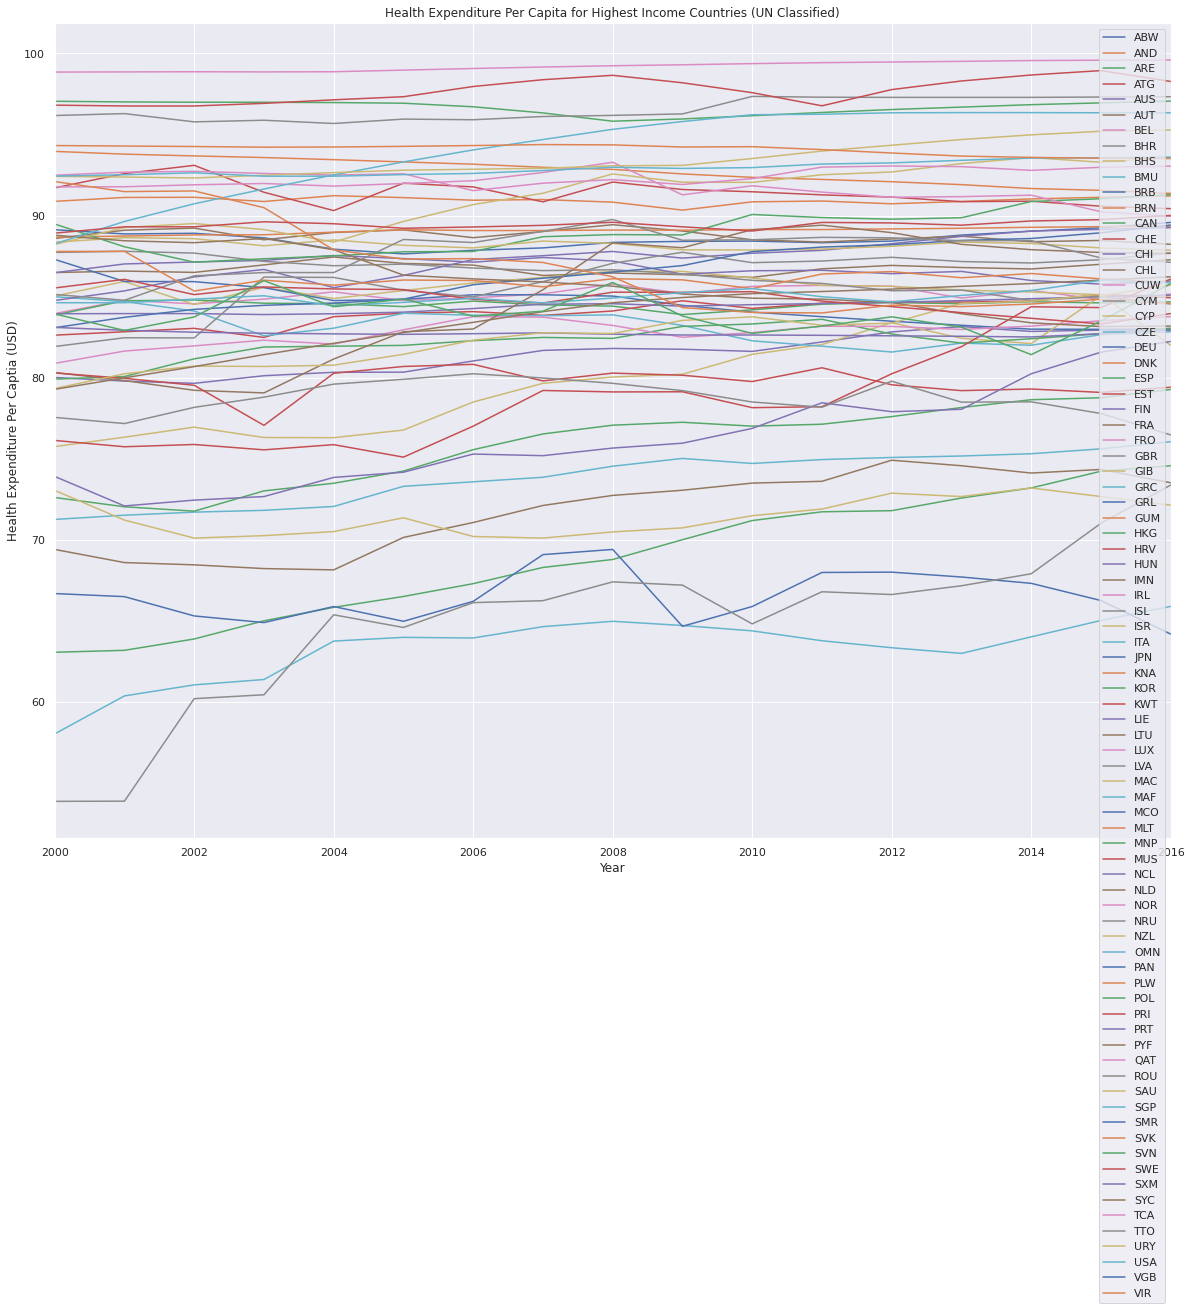

In [49]:
# Highest Income Healthcare Expenditures
sn.set(rc={'figure.figsize':(20, 15)})

healthcare_ex_plot_df2 = healthcare_ex_pivot_no_change_df.copy()
healthcare_ex_plot_df2 = pd.merge(left=high_income_df, right=healthcare_ex_plot_df2, left_on='Country Code', right_on='Country_Code', how='left')
healthcare_ex_plot_df2

healthcare_ex_plot_df2['Year'] = pd.to_datetime(healthcare_ex_plot_df2['Year'], format='%Y')
healthcare_ex_plot_df2.index = healthcare_ex_plot_df2['Year']
healthcare_ex_plot_df2.groupby('Country_Code')['value'].plot(legend=True)
plt.xlabel('Year')
plt.ylabel('Health Expenditure Per Captia (USD)')
plt.title('Health Expenditure Per Capita for Highest Income Countries (UN Classified)')
plt.show()

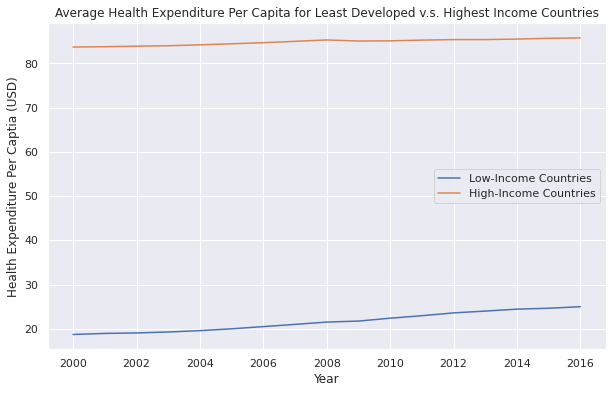

In [50]:
# Plotting Averages of the Two Country Groups Against One Another 
sn.set(rc={'figure.figsize':(10, 6)})
low_income_year_avg = healthcare_ex_plot_df.groupby(healthcare_ex_plot_df.index).mean()
high_income_year_avg = healthcare_ex_plot_df2.groupby(healthcare_ex_plot_df2.index).mean()
total_df = pd.merge(left=low_income_year_avg, right=high_income_year_avg, left_on=low_income_year_avg.index, right_on=high_income_year_avg.index, how='left').rename(columns={'key_0' : 'Year', 'value_x': 'Low-Income', 'value_y': 'High-Income'})


plt.plot(total_df['Year'], total_df['Low-Income'])
plt.plot(total_df['Year'], total_df['High-Income'])
plt.title('Average Health Expenditure Per Capita for Least Developed v.s. Highest Income Countries')
plt.xlabel('Year')
plt.ylabel('Health Expenditure Per Captia (USD)')
plt.legend(['Low-Income Countries','High-Income Countries'])
plt.show()

#### 2.3.3 Percent Children Immunized for Measles

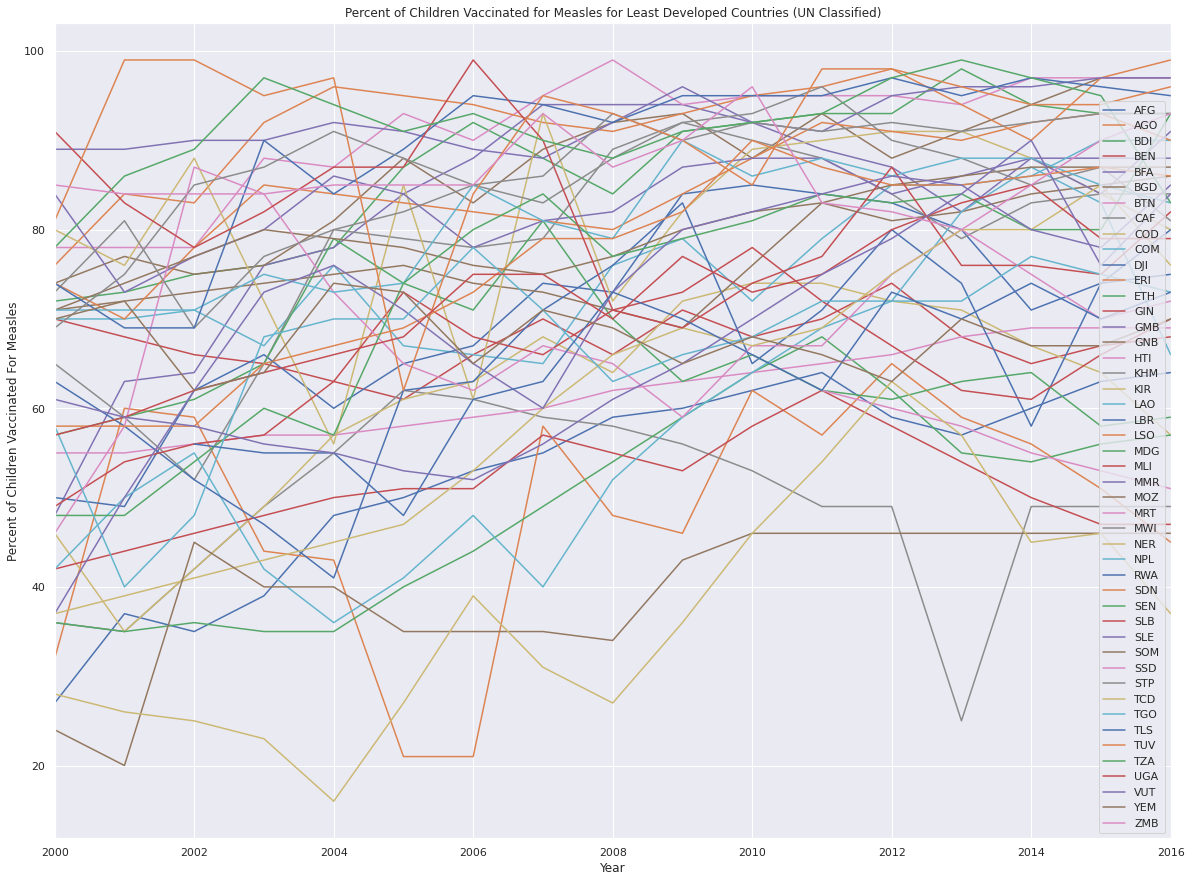

In [51]:
#Least Developed Measles
sn.set(rc={'figure.figsize':(20, 15)})
pivot_no_change_df = measles_vaccinations_df.melt(['Country Name', 'Country Code'], var_name='Year').rename(columns={'Country Code': 'Country_Code'})


plot_df = pivot_no_change_df.copy()
plot_df = pd.merge(left=least_developed_df, right=plot_df, left_on='Country Code', right_on='Country_Code', how='left')
plot_df

plot_df['Year'] = pd.to_datetime(plot_df['Year'], format='%Y')
plot_df.index = plot_df['Year']
plot_df.groupby('Country_Code')['value'].plot(legend=True)
plt.xlabel('Year')
plt.ylabel('Percent of Children Vaccinated For Measles')
plt.title('Percent of Children Vaccinated for Measles for Least Developed Countries (UN Classified)')
plt.show()

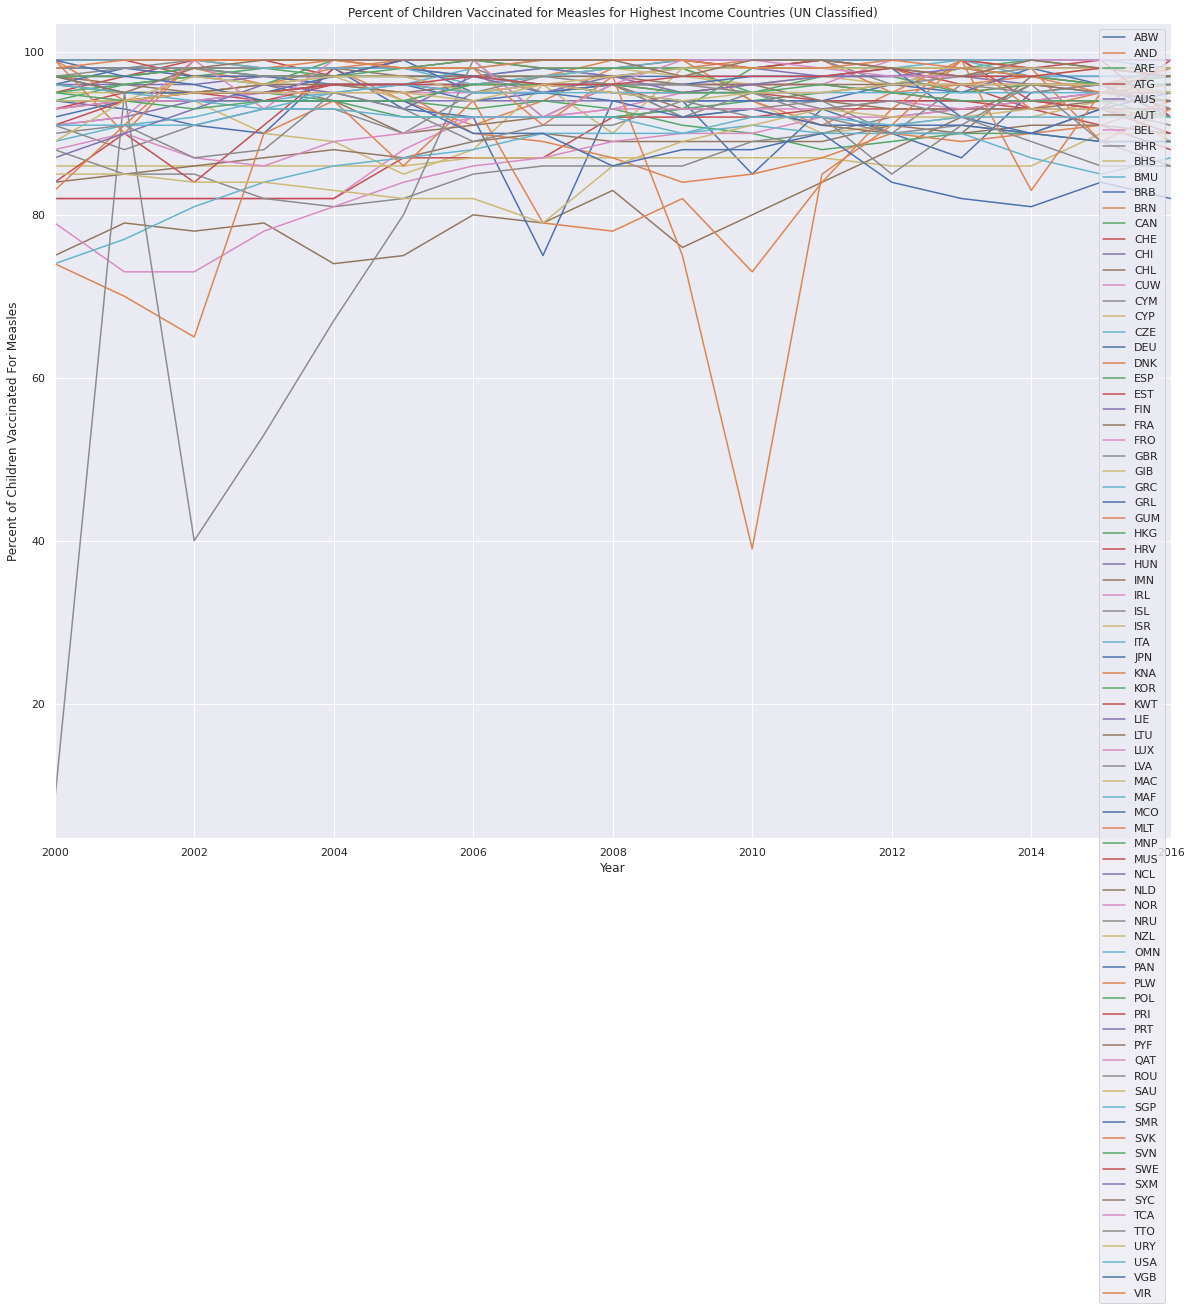

In [52]:
# Highest Income Measles
sn.set(rc={'figure.figsize':(20, 15)})

plot_df2 = pivot_no_change_df.copy()
plot_df2 = pd.merge(left=high_income_df, right=plot_df2, left_on='Country Code', right_on='Country_Code', how='left')
plot_df2

plot_df2['Year'] = pd.to_datetime(plot_df2['Year'], format='%Y')
plot_df2.index = plot_df2['Year']
plot_df2.groupby('Country_Code')['value'].plot(legend=True)
plt.xlabel('Year')
plt.ylabel('Percent of Children Vaccinated For Measles')
plt.title('Percent of Children Vaccinated for Measles for Highest Income Countries (UN Classified)')
plt.show()

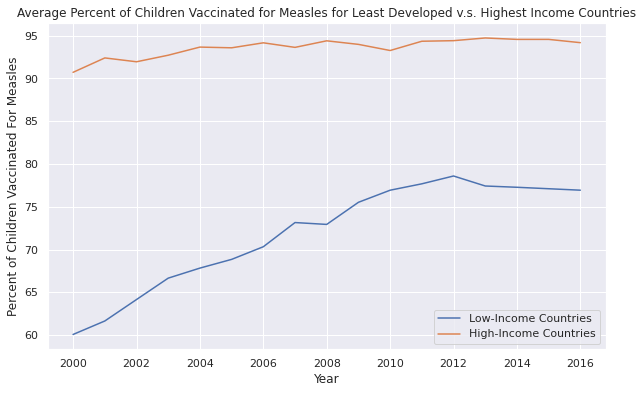

In [53]:
# Plotting Averages of the Two Country Groups Against One Another 
sn.set(rc={'figure.figsize':(10, 6)})
low_income_year_avg = plot_df.groupby(plot_df.index).mean()
high_income_year_avg = plot_df2.groupby(plot_df2.index).mean()
total_df = pd.merge(left=low_income_year_avg, right=high_income_year_avg, left_on=low_income_year_avg.index, right_on=high_income_year_avg.index, how='left').rename(columns={'key_0' : 'Year', 'value_x': 'Low-Income', 'value_y': 'High-Income'})


plt.plot(total_df['Year'], total_df['Low-Income'])
plt.plot(total_df['Year'], total_df['High-Income'])
plt.xlabel('Year')
plt.ylabel('Percent of Children Vaccinated For Measles')
plt.title('Average Percent of Children Vaccinated for Measles for Least Developed v.s. Highest Income Countries')
plt.legend(['Low-Income Countries','High-Income Countries'])
plt.show()

This healthcare centric data reflects the patterns seen with the other two categories, although in some cases, may see less disparities. The average TB incidence, however, is not one of those cases and had five-fold more cases in the least developed countries compared to the highest income countries in 2016. This may be due to a slew of factors, ranging from lack of healthcare access to climate change factors. However, we do see a slight downward trend, which indicates slow development of general healthcare infrastruture in the country. This slight decline may be due to the slight increase in average health expenditure per capita in the least developed countries, which may be another area of collinearity to address. However, here as well, we see a large disparity between the highest and least developed countries. 

The last dataset, which is percent of children immunized with the measles vaccine, shows the least disparity between the least developed and most developed countries, with the average being a little less than 80% in the least developed countries compared to 95% in the highest income countries. This may be a weak factor to explain/predict the GDP growth and overall level of development but still indicates disparate access between the two income brackets of countries. 



# **Section 3: Transforming Data for ML Models**

Now comes the fun part! Oh wait, not yet… We need to first transform the data that can be used for the modeling. Since the data is time-series based, each year is a column. However, we need to add all nine features together, necessitating that we make year a column itself. We use the df.melt() function to essentially get the transpose of our original dataframes so all of our features can be joined into the conventional structure.

### 3.1 Calculating Percent Change


We will calculate the annual percentage changes for each of our features and use these values as opposed to the raw data points for our machine learning models. Our models will use the annual percentage changes of the different features to predict the respective annual percentage change in GDP per capita. By using annual percentage changes, we remove the year variable in the aim of making a model that is potentially generalizable for any year.

In [54]:
# GDP and urban sprawl data already represented by annual % change so no need to calculate

In [55]:
co2_emissions_change_df = co2_emissions_df.copy()
for i in range(2001, 2017):
  co2_emissions_change_df[str(i)] = (co2_emissions_df[str(i)] - co2_emissions_df[str(i - 1)]) / co2_emissions_df[str(i - 1)]

co2_emissions_change_df.drop(columns='2000', inplace=True)
co2_emissions_change_df

Country Name  ...      2016
0                                   Afghanistan  ... -0.068441
1                                       Albania  ... -0.016220
2                                       Algeria  ... -0.040467
3                                American Samoa  ...       NaN
4                                       Andorra  ...  0.017085
..                                          ...  ...       ...
259                          Sub-Saharan Africa  ... -0.001198
260  Sub-Saharan Africa (excluding high income)  ... -0.001202
261   Sub-Saharan Africa (IDA & IBRD countries)  ... -0.001198
262                         Upper middle income  ... -0.014989
263                                       World  ... -0.017896

[264 rows x 18 columns]

In [56]:
forest_change_df = forest_area_df.copy()
for i in range(2001,2017):
  forest_change_df[str(i)] = (forest_area_df[str(i)] - forest_area_df[str(i - 1)])/forest_area_df[str(i - 1)]

forest_change_df.drop(columns='2000', inplace=True)
forest_change_df

Country Name  ...      2016
0                                     Argentina  ... -0.002990
1                                     Australia  ...  0.007083
2                                        Brazil  ... -0.003578
3                                         China  ...  0.010298
4                                        France  ...  0.004954
..                                          ...  ...       ...
259                          Sub-Saharan Africa  ... -0.006205
260  Sub-Saharan Africa (excluding high income)  ... -0.006205
261   Sub-Saharan Africa (IDA & IBRD countries)  ... -0.006205
262                         Upper middle income  ... -0.000177
263                                       World  ... -0.000827

[264 rows x 18 columns]

In [57]:
salaried_workers_change_df = salaried_workers_df.copy()
for i in range(2001, 2017):
  salaried_workers_change_df[str(i)] = (salaried_workers_df[str(i)] - salaried_workers_df[str(i - 1)]) / salaried_workers_df[str(i - 1)]

salaried_workers_change_df.drop(columns='2000', inplace=True)
salaried_workers_change_df

Country Name  ...      2016
0                                   Afghanistan  ...  0.044965
1                                       Albania  ...  0.005098
2                                       Algeria  ... -0.002768
3                                American Samoa  ...       NaN
4                                       Andorra  ...       NaN
..                                          ...  ...       ...
259                          Sub-Saharan Africa  ...  0.008400
260  Sub-Saharan Africa (excluding high income)  ...  0.008516
261   Sub-Saharan Africa (IDA & IBRD countries)  ...  0.008400
262                         Upper middle income  ...  0.002379
263                                       World  ...  0.006131

[264 rows x 18 columns]

In [58]:
adolescent_fertility_change_df = adolescent_fertility_df.copy()
for i in range(2001,2017):
  adolescent_fertility_change_df[str(i)] = (adolescent_fertility_df[str(i)] - adolescent_fertility_df[str(i - 1)])/adolescent_fertility_df[str(i - 1)]

adolescent_fertility_change_df.drop(columns='2000', inplace=True)
adolescent_fertility_change_df

Country Name Country Code      2001  ...      2014      2015      2016
0           Afghanistan          AFG -0.024417  ... -0.052964 -0.055939 -0.059240
1               Albania          ALB -0.005095  ... -0.000579 -0.000628 -0.000580
2               Algeria          DZA -0.088295  ... -0.025106 -0.025844 -0.026436
3        American Samoa          ASM       NaN  ...       NaN       NaN       NaN
4               Andorra          AND       NaN  ...       NaN       NaN       NaN
..                  ...          ...       ...  ...       ...       ...       ...
237  West Bank and Gaza          PSE -0.065216  ... -0.015180 -0.015414 -0.015655
238               World          WLD -0.027897  ... -0.008780 -0.010173 -0.012869
239         Yemen, Rep.          YEM -0.053758  ... -0.022112 -0.022612 -0.023135
240              Zambia          ZMB -0.002275  ... -0.033058 -0.034178 -0.035399
241            Zimbabwe          ZWE -0.006272  ... -0.015644 -0.015902 -0.016150

[242 rows x 18 columns]

In [59]:
age_dependency_change_df = age_dependency_df.copy()
for i in range(2001,2017):
  age_dependency_change_df[str(i)] = (age_dependency_df[str(i)] - age_dependency_df[str(i - 1)])/age_dependency_df[str(i - 1)]

age_dependency_change_df.drop(columns='2000', inplace=True)
age_dependency_change_df

Country Name Country Code      2001  ...      2014      2015      2016
0           Afghanistan          AFG -0.003852  ... -0.027936 -0.028530 -0.024761
1               Albania          ALB -0.017085  ... -0.021127 -0.015522 -0.000341
2               Algeria          DZA -0.044525  ...  0.019683  0.021862  0.022437
3        American Samoa          ASM       NaN  ...       NaN       NaN       NaN
4               Andorra          AND       NaN  ...       NaN       NaN       NaN
..                  ...          ...       ...  ...       ...       ...       ...
237  West Bank and Gaza          PSE -0.012939  ... -0.015293 -0.012860 -0.010810
238               World          WLD -0.011329  ...  0.000019  0.000722  0.002608
239         Yemen, Rep.          YEM -0.023337  ... -0.012476 -0.013405 -0.011281
240              Zambia          ZMB  0.007541  ... -0.012574 -0.013636 -0.011822
241            Zimbabwe          ZWE -0.009174  ... -0.001991 -0.002559 -0.004012

[242 rows x 18 columns]

In [60]:
health_expenditures_change_df = health_expenditures_df.copy()
for i in range(2001, 2017):
  health_expenditures_change_df[str(i)] = (health_expenditures_df[str(i)] - health_expenditures_df[str(i - 1)]) / health_expenditures_df[str(i - 1)]

health_expenditures_change_df.drop(columns='2000', inplace=True)
health_expenditures_change_df

Country Name  ...      2016
0                                   Afghanistan  ...  0.044965
1                                       Albania  ...  0.005098
2                                       Algeria  ... -0.002768
3                                American Samoa  ...       NaN
4                                       Andorra  ...       NaN
..                                          ...  ...       ...
259                          Sub-Saharan Africa  ...  0.008400
260  Sub-Saharan Africa (excluding high income)  ...  0.008516
261   Sub-Saharan Africa (IDA & IBRD countries)  ...  0.008400
262                         Upper middle income  ...  0.002379
263                                       World  ...  0.006131

[264 rows x 18 columns]

In [61]:
measles_change_df = measles_vaccinations_df.copy()
for i in range(2001,2017):
  measles_change_df[str(i)] = (measles_vaccinations_df[str(i)] - measles_vaccinations_df[str(i - 1)])/measles_vaccinations_df[str(i - 1)]

measles_change_df.drop(columns='2000', inplace=True)
measles_change_df

Country Name  ...      2016
0                                     Argentina  ...  0.011236
1                                     Australia  ...  0.000000
2                                        Brazil  ... -0.010417
3                                         China  ...  0.000000
4                                        France  ... -0.010989
..                                          ...  ...       ...
259                          Sub-Saharan Africa  ...  0.003478
260  Sub-Saharan Africa (excluding high income)  ...  0.003523
261   Sub-Saharan Africa (IDA & IBRD countries)  ...  0.003478
262                         Upper middle income  ...  0.001678
263                                       World  ...  0.003002

[264 rows x 18 columns]

In [62]:
tb_change_df = tb_df.copy()
for i in range(2001,2017):
  tb_change_df[str(i)] = (tb_df[str(i)] - tb_df[str(i - 1)])/tb_df[str(i - 1)]

tb_change_df.drop(columns='2000', inplace=True)
tb_change_df

Country Country Code  ...      2015      2016
0                           Afghanistan          AFG  ...  0.000482  0.002525
1                               Albania          ALB  ...  0.024255  0.001600
2                               Algeria          DZA  ...  0.049736 -0.052961
3                               Andorra          AND  ... -0.274709  0.009237
4                                Angola          AGO  ... -0.014480 -0.004784
..                                  ...          ...  ...       ...       ...
189  Venezuela (Bolivarian Republic of)          VEN  ...  0.111143  0.132467
190                            Viet Nam          VNM  ... -0.026177 -0.031669
191                               Yemen          YEM  ...  0.055761 -0.024673
192                              Zambia          ZMB  ... -0.045597 -0.045239
193                            Zimbabwe          ZWE  ... -0.145908 -0.015378

[194 rows x 18 columns]

### 3.2 Melting the Data

For each indicator/feature dataframe, we are now going to melt it so that the columns of the years can be shifted into rows. The purpose of this is to create datapoints where we have a pair of features and a label for each year, which makes it more convenient to feed into the model.

In [63]:
gdp_pivot_df = gdp_df.melt(['Country Name', 'Country Code'], var_name='Year').rename(columns={'Country Code': 'Country_Code'})
gdp_pivot_df

Country Name Country_Code  Year  value
0                                    Afghanistan          AFG  2000    NaN
1                                        Albania          ALB  2000  7.634
2                                        Algeria          DZA  2000  2.400
3                                 American Samoa          ASM  2000    NaN
4                                        Andorra          AND  2000  1.913
...                                          ...          ...   ...    ...
4483                          Sub-Saharan Africa          SSF  2016 -1.517
4484  Sub-Saharan Africa (excluding high income)          SSA  2016 -1.542
4485   Sub-Saharan Africa (IDA & IBRD countries)          TSS  2016 -1.517
4486                         Upper middle income          UMC  2016  3.145
4487                                       World          WLD  2016  1.426

[4488 rows x 4 columns]

In [64]:
co2_emissions_pivot_df = co2_emissions_change_df.melt(['Country Name', 'Country Code'], var_name='Year').rename(columns={'Country Code': 'Country_Code'})
co2_emissions_pivot_df

Country Name Country_Code  Year     value
0                                    Afghanistan          AFG  2001  0.027027
1                                        Albania          ALB  2001  0.076687
2                                        Algeria          DZA  2001 -0.053710
3                                 American Samoa          ASM  2001       NaN
4                                        Andorra          AND  2001 -0.028931
...                                          ...          ...   ...       ...
4219                          Sub-Saharan Africa          SSF  2016 -0.001198
4220  Sub-Saharan Africa (excluding high income)          SSA  2016 -0.001202
4221   Sub-Saharan Africa (IDA & IBRD countries)          TSS  2016 -0.001198
4222                         Upper middle income          UMC  2016 -0.014989
4223                                       World          WLD  2016 -0.017896

[4224 rows x 4 columns]

In [65]:
forest_pivot_df = forest_change_df.melt(['Country Name', 'Country Code'], var_name='Year').rename(columns={'Country Code': 'Country_Code'})
forest_pivot_df

Country Name Country_Code  Year     value
0                                      Argentina          ARG  2001 -0.009479
1                                      Australia          AUS  2001 -0.001721
2                                         Brazil          BRA  2001 -0.007169
3                                          China          CHN  2001  0.013339
4                                         France          FRA  2001  0.007398
...                                          ...          ...   ...       ...
4219                          Sub-Saharan Africa          SSF  2016 -0.006205
4220  Sub-Saharan Africa (excluding high income)          SSA  2016 -0.006205
4221   Sub-Saharan Africa (IDA & IBRD countries)          TSS  2016 -0.006205
4222                         Upper middle income          UMC  2016 -0.000177
4223                                       World          WLD  2016 -0.000827

[4224 rows x 4 columns]

In [66]:
urban_sprawl_pivot_df = urban_sprawl_df.melt(['Country Name', 'Country Code'], var_name='Year').rename(columns={'Country Code': 'Country_Code'})
urban_sprawl_pivot_df

Country Name Country_Code  Year  value
0                                      Argentina          ARG  2000  1.314
1                                      Australia          AUS  2000  1.032
2                                         Brazil          BRA  2000  2.285
3                                          China          CHN  2000  3.649
4                                         France          FRA  2000  1.024
...                                          ...          ...   ...    ...
4483                          Sub-Saharan Africa          SSF  2016  4.117
4484  Sub-Saharan Africa (excluding high income)          SSA  2016  4.124
4485   Sub-Saharan Africa (IDA & IBRD countries)          TSS  2016  4.117
4486                         Upper middle income          UMC  2016  2.119
4487                                       World          WLD  2016  2.019

[4488 rows x 4 columns]

In [67]:
salaried_workers_pivot_df = salaried_workers_change_df.melt(['Country Name', 'Country Code'], var_name='Year').rename(columns={'Country Code': 'Country_Code'})
salaried_workers_pivot_df

Country Name Country_Code  Year     value
0                                    Afghanistan          AFG  2001 -0.068249
1                                        Albania          ALB  2001  0.033714
2                                        Algeria          DZA  2001  0.005347
3                                 American Samoa          ASM  2001       NaN
4                                        Andorra          AND  2001       NaN
...                                          ...          ...   ...       ...
4219                          Sub-Saharan Africa          SSF  2016  0.008400
4220  Sub-Saharan Africa (excluding high income)          SSA  2016  0.008516
4221   Sub-Saharan Africa (IDA & IBRD countries)          TSS  2016  0.008400
4222                         Upper middle income          UMC  2016  0.002379
4223                                       World          WLD  2016  0.006131

[4224 rows x 4 columns]

In [68]:
adolescent_fertility_pivot_df = adolescent_fertility_change_df.melt(['Country Name', 'Country Code'], var_name='Year').rename(columns={'Country Code': 'Country_Code'})
adolescent_fertility_pivot_df

Country Name Country_Code  Year     value
0            Afghanistan          AFG  2001 -0.024417
1                Albania          ALB  2001 -0.005095
2                Algeria          DZA  2001 -0.088295
3         American Samoa          ASM  2001       NaN
4                Andorra          AND  2001       NaN
...                  ...          ...   ...       ...
3867  West Bank and Gaza          PSE  2016 -0.015655
3868               World          WLD  2016 -0.012869
3869         Yemen, Rep.          YEM  2016 -0.023135
3870              Zambia          ZMB  2016 -0.035399
3871            Zimbabwe          ZWE  2016 -0.016150

[3872 rows x 4 columns]

In [69]:
age_dependency_pivot_df = age_dependency_change_df.melt(['Country Name', 'Country Code'], var_name='Year').rename(columns={'Country Code': 'Country_Code'})
age_dependency_pivot_df

Country Name Country_Code  Year     value
0            Afghanistan          AFG  2001 -0.003852
1                Albania          ALB  2001 -0.017085
2                Algeria          DZA  2001 -0.044525
3         American Samoa          ASM  2001       NaN
4                Andorra          AND  2001       NaN
...                  ...          ...   ...       ...
3867  West Bank and Gaza          PSE  2016 -0.010810
3868               World          WLD  2016  0.002608
3869         Yemen, Rep.          YEM  2016 -0.011281
3870              Zambia          ZMB  2016 -0.011822
3871            Zimbabwe          ZWE  2016 -0.004012

[3872 rows x 4 columns]

In [70]:
health_expenditures_pivot_df = health_expenditures_change_df.melt(['Country Name', 'Country Code'], var_name='Year').rename(columns={'Country Code': 'Country_Code'})
health_expenditures_pivot_df

Country Name Country_Code  Year     value
0                                    Afghanistan          AFG  2001 -0.068249
1                                        Albania          ALB  2001  0.033714
2                                        Algeria          DZA  2001  0.005347
3                                 American Samoa          ASM  2001       NaN
4                                        Andorra          AND  2001       NaN
...                                          ...          ...   ...       ...
4219                          Sub-Saharan Africa          SSF  2016  0.008400
4220  Sub-Saharan Africa (excluding high income)          SSA  2016  0.008516
4221   Sub-Saharan Africa (IDA & IBRD countries)          TSS  2016  0.008400
4222                         Upper middle income          UMC  2016  0.002379
4223                                       World          WLD  2016  0.006131

[4224 rows x 4 columns]

In [71]:
measles_vaccinations_pivot_df = measles_change_df.melt(['Country Name', 'Country Code'], var_name='Year').rename(columns={'Country Code': 'Country_Code'})
measles_vaccinations_pivot_df

Country Name Country_Code  Year     value
0                                      Argentina          ARG  2001 -0.021978
1                                      Australia          AUS  2001  0.010989
2                                         Brazil          BRA  2001  0.000000
3                                          China          CHN  2001  0.011905
4                                         France          FRA  2001  0.011905
...                                          ...          ...   ...       ...
4219                          Sub-Saharan Africa          SSF  2016  0.003478
4220  Sub-Saharan Africa (excluding high income)          SSA  2016  0.003523
4221   Sub-Saharan Africa (IDA & IBRD countries)          TSS  2016  0.003478
4222                         Upper middle income          UMC  2016  0.001678
4223                                       World          WLD  2016  0.003002

[4224 rows x 4 columns]

In [72]:
tb_pivot_df = tb_change_df.melt(['Country', 'Country Code'], var_name='Year').rename(columns={'Country Code': 'Country_Code'})
tb_pivot_df

Country Country_Code  Year     value
0                            Afghanistan          AFG  2001  0.011043
1                                Albania          ALB  2001 -0.063718
2                                Algeria          DZA  2001 -0.013013
3                                Andorra          AND  2001 -0.167690
4                                 Angola          AGO  2001  0.026763
...                                  ...          ...   ...       ...
3099  Venezuela (Bolivarian Republic of)          VEN  2016  0.132467
3100                            Viet Nam          VNM  2016 -0.031669
3101                               Yemen          YEM  2016 -0.024673
3102                              Zambia          ZMB  2016 -0.045239
3103                            Zimbabwe          ZWE  2016 -0.015378

[3104 rows x 4 columns]

###3.3 Joining all the indicator dataframes and preparing it for the ML models

Now that we have analyzed/explored all the features separately in Section 2, and prepared the features more accordingly to be put into a model in 3.1 and 3.2, we can now join all of the features and labels together. We used pandasql to achieve this since it was a lot more intuitive and cleaner to do it this way. We essentially used an SQL inner join on the country code and the year between each feature dataframe and the label (GDP per capita growth)

In [73]:
#Joining all the dataframes of all the indicators

join_query = '''

SELECT gdp_pivot_df.Country_Code, gdp_pivot_df.Year, gdp_pivot_df.value as GDP_Per_Capita_Growth, 

co2_emissions_pivot_df.value as CO2_Emission,
forest_pivot_df.value as Forest_Area, 
urban_sprawl_pivot_df.value as Urban_Sprawl, 

health_expenditures_pivot_df.value as Health_Expenditure, 
tb_pivot_df.value as TB_Incidence, 
measles_vaccinations_pivot_df.value as Measles_Vaccination,

salaried_workers_pivot_df.value as Salaried_Workers, 
adolescent_fertility_pivot_df.value as Adolescent_Fertility,
age_dependency_pivot_df.value as Age_Dependency_Ratio


FROM gdp_pivot_df

INNER JOIN co2_emissions_pivot_df
ON (gdp_pivot_df.Country_Code = co2_emissions_pivot_df.Country_Code) AND (gdp_pivot_df.Year = co2_emissions_pivot_df.Year)

INNER JOIN forest_pivot_df
ON (gdp_pivot_df.Country_Code = forest_pivot_df.Country_Code) AND (gdp_pivot_df.Year = forest_pivot_df.Year)

INNER JOIN urban_sprawl_pivot_df
ON (gdp_pivot_df.Country_Code = urban_sprawl_pivot_df.Country_Code) AND (gdp_pivot_df.Year = urban_sprawl_pivot_df.Year)

INNER JOIN salaried_workers_pivot_df
ON (gdp_pivot_df.Country_Code = salaried_workers_pivot_df.Country_Code) AND (gdp_pivot_df.Year = salaried_workers_pivot_df.Year)

INNER JOIN adolescent_fertility_pivot_df
ON (gdp_pivot_df.Country_Code = adolescent_fertility_pivot_df.Country_Code) AND (gdp_pivot_df.Year = adolescent_fertility_pivot_df.Year)

INNER JOIN age_dependency_pivot_df
ON (gdp_pivot_df.Country_Code = age_dependency_pivot_df.Country_Code) AND (gdp_pivot_df.Year = age_dependency_pivot_df.Year)

INNER JOIN health_expenditures_pivot_df
ON (gdp_pivot_df.Country_Code = health_expenditures_pivot_df.Country_Code) AND (gdp_pivot_df.Year = health_expenditures_pivot_df.Year)

INNER JOIN measles_vaccinations_pivot_df
ON (gdp_pivot_df.Country_Code = measles_vaccinations_pivot_df.Country_Code) AND (gdp_pivot_df.Year = measles_vaccinations_pivot_df.Year)

INNER JOIN tb_pivot_df
ON (gdp_pivot_df.Country_Code = tb_pivot_df.Country_Code) AND (gdp_pivot_df.Year = tb_pivot_df.Year)

'''

sdf = ps.sqldf(join_query, locals())
sdf



Country_Code  Year  ...  Adolescent_Fertility  Age_Dependency_Ratio
0             AFG  2001  ...             -0.024417             -0.003852
1             ALB  2001  ...             -0.005095             -0.017085
2             DZA  2001  ...             -0.088295             -0.044525
3             AND  2001  ...                   NaN                   NaN
4             AGO  2001  ...             -0.009827              0.000302
...           ...   ...  ...                   ...                   ...
3067          VEN  2016  ...             -0.005745             -0.005404
3068          VNM  2016  ...             -0.056992              0.007783
3069          YEM  2016  ...             -0.023135             -0.011281
3070          ZMB  2016  ...             -0.035399             -0.011822
3071          ZWE  2016  ...             -0.016150             -0.004012

[3072 rows x 12 columns]

We just wanted to verify that our features did not have too much null data so that we can maximize the rows we get to keep to use for the model

In [74]:
# looking at how many NaNs there are for each row
sdf_temp_2 = pd.merge(left = least_developed_df, right = sdf, left_on='Country Code', right_on = 'Country_Code', how = 'left')
sdf_temp_2 = sdf_temp_2[sdf_temp_2['Year'] != '2010']
sdf_temp_2 = sdf_temp_2[sdf_temp_2['Year'] != '2007']
sdf_temp_2 = sdf_temp_2[sdf_temp_2['Year'] != '2008']
sdf_temp_2 = sdf_temp_2[sdf_temp_2['Year'] != '2009']
print(sdf_temp_2.isnull().sum(axis=0))

sdf_temp_2

Country                   0
Country Code              0
Country_Code              0
Year                      0
GDP_Per_Capita_Growth    36
                         ..
TB_Incidence             14
Measles_Vaccination       9
Salaried_Workers         24
Adolescent_Fertility     12
Age_Dependency_Ratio     17
Length: 14, dtype: int64


Country Country Code  ... Adolescent_Fertility Age_Dependency_Ratio
0    AFGHANISTAN          AFG  ...            -0.024417            -0.003852
1    AFGHANISTAN          AFG  ...            -0.025028            -0.007520
2    AFGHANISTAN          AFG  ...            -0.039656            -0.009339
3    AFGHANISTAN          AFG  ...            -0.041301            -0.010287
4    AFGHANISTAN          AFG  ...            -0.043073            -0.011452
..           ...          ...  ...                  ...                  ...
747       ZAMBIA          ZMB  ...            -0.033743            -0.010475
748       ZAMBIA          ZMB  ...            -0.032001            -0.011393
749       ZAMBIA          ZMB  ...            -0.033058            -0.012574
750       ZAMBIA          ZMB  ...            -0.034178            -0.013636
751       ZAMBIA          ZMB  ...            -0.035399            -0.011822

[564 rows x 14 columns]

We noticed that the GDP might be unfairly impacted due to the Global Financial Crisis and its aftermath so we decided to remove those years from our data

In [75]:
#Removing datapoints from 2007 - 2010 from our data

sdf_2 = pd.merge(left = least_developed_df, right = sdf, left_on='Country Code', right_on = 'Country_Code', how = 'left').dropna()
sdf_2 = sdf_2[sdf_2['Year'] != '2010']
sdf_2 = sdf_2[sdf_2['Year'] != '2007']
sdf_2 = sdf_2[sdf_2['Year'] != '2008']
sdf_2 = sdf_2[sdf_2['Year'] != '2009']
sdf_2

Country Country Code  ... Adolescent_Fertility Age_Dependency_Ratio
2    AFGHANISTAN          AFG  ...            -0.039656            -0.009339
3    AFGHANISTAN          AFG  ...            -0.041301            -0.010287
4    AFGHANISTAN          AFG  ...            -0.043073            -0.011452
5    AFGHANISTAN          AFG  ...            -0.045019             0.006262
10   AFGHANISTAN          AFG  ...            -0.063407            -0.016682
..           ...          ...  ...                  ...                  ...
747       ZAMBIA          ZMB  ...            -0.033743            -0.010475
748       ZAMBIA          ZMB  ...            -0.032001            -0.011393
749       ZAMBIA          ZMB  ...            -0.033058            -0.012574
750       ZAMBIA          ZMB  ...            -0.034178            -0.013636
751       ZAMBIA          ZMB  ...            -0.035399            -0.011822

[492 rows x 14 columns]

We now remove any columns that are not features to be used in the ML models

In [76]:
#Removing columns apart from the features

sdf_final = sdf_2.drop(columns=['Country', 'Country Code', 'Country_Code', 'Year'])
sdf_final

GDP_Per_Capita_Growth  ...  Age_Dependency_Ratio
2                    3.868  ...             -0.009339
3                   -2.875  ...             -0.010287
4                    7.208  ...             -0.011452
5                    2.253  ...              0.006262
10                  -2.681  ...             -0.016682
..                     ...  ...                   ...
747                  4.310  ...             -0.010475
748                  1.810  ...             -0.011393
749                  1.481  ...             -0.012574
750                 -0.188  ...             -0.013636
751                  0.706  ...             -0.011822

[492 rows x 10 columns]

Before applying any ML models to the data, we wanted to analyze the features' relationships with one another through a correlation matrix and collinearity plots and apply any changes necessary to the features. The comments in the code cells will walk you through our logic and reasoning

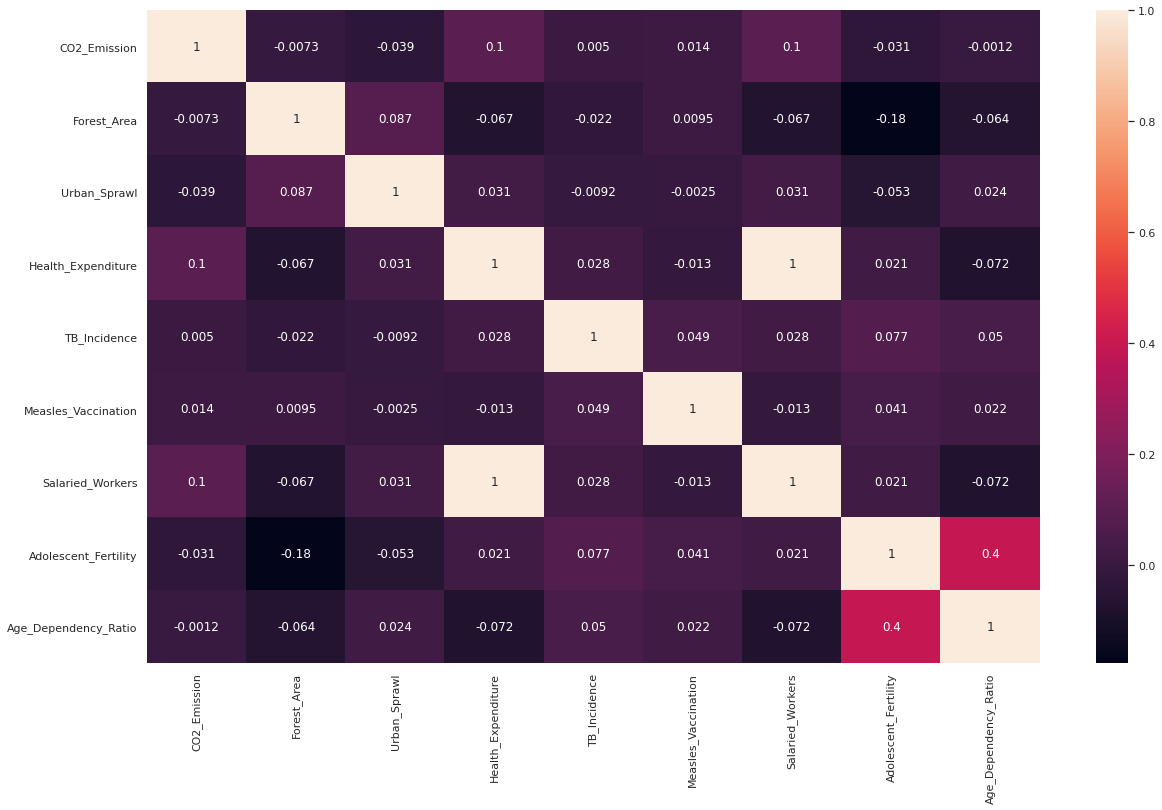

In [77]:
# How correlated is the data
corr_matrix = sdf_final.drop(columns = ['GDP_Per_Capita_Growth']).corr()

plt.figure(figsize=(20,12))
sn.heatmap(corr_matrix, annot=True)
plt.show()

It seems that most of the features are relatively uncorrelated except for adolescent fertility and age dependency ratio

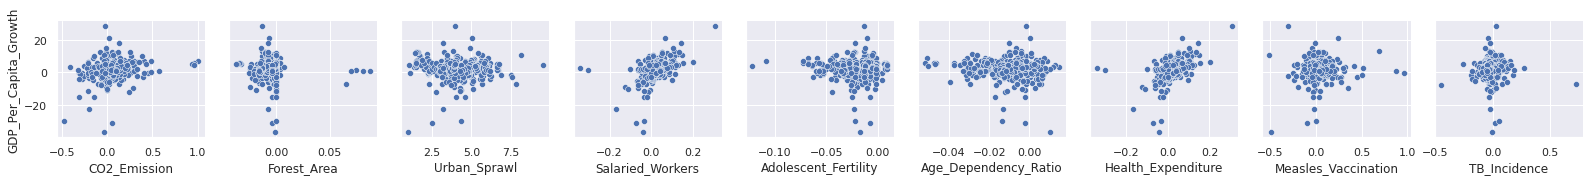

In [78]:
#Looking at potential relationships with pairwise plotting 
sdf_plot = sdf_2.drop(columns=['Country', 'Country_Code', 'Year'])
sn.pairplot(sdf_plot, x_vars=['CO2_Emission',	'Forest_Area','Urban_Sprawl', 'Salaried_Workers',
                              'Adolescent_Fertility', 'Age_Dependency_Ratio', 'Health_Expenditure',
                              'Measles_Vaccination', 'TB_Incidence'],
            y_vars=['GDP_Per_Capita_Growth'])

In [79]:
#The above necessitates transformations for the features to ensure linearity, the most extreme case being Forest Area 
#To make Forest Area more linear, we apply the following transformation to it 

sdf_temp = sdf_final.copy()
sdf_temp['Forest_Area'] = sdf_temp['Forest_Area'].apply(lambda x: np.log((25 * x) + 1))
sdf_model = sdf_temp

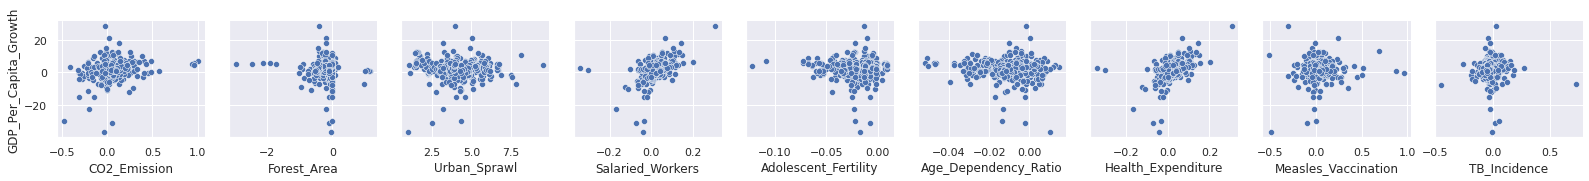

In [80]:
#Tranformation of Forest_Area improved linearity 
sn.pairplot(sdf_temp, x_vars=['CO2_Emission',	'Forest_Area','Urban_Sprawl', 'Salaried_Workers',
                              'Adolescent_Fertility', 'Age_Dependency_Ratio', 'Health_Expenditure',
                              'Measles_Vaccination', 'TB_Incidence'],
            y_vars=['GDP_Per_Capita_Growth'])

The transformation to improve Forest_Area's linearity seemed to have a helped a little, but not too much. However, this seems to be the best we can work with, so onward to the ML models!

#Section 4: Models & Prediction!!!

After a long and tedious process, we have finally arrived at the exciting part. For the purpose of our objective, we will be using supervised learning - more specifically regression to predict GDP growth per capita. First we will run a basic linear regression, then regularize the data and apply PCA to see if it improves the performance of the model. Lastly, we will construct a simple neural network and then compare all of the models' performances

###4.1 Linear Regression with all features and then attempting regularization

With all the 9 features from the dataset, we first run basic linear regression and compute the root mean squared error (RSME) and the R^2 coefficient. Then, we construct linear regression models based on three types of regularization - L1(Lasso), L2(Ridge), and Elastic Net which is a combination of both L1 and L2. For each of the three regularization techniques, we perform cross-validation to determine the optimal values for the alpha parameter. We also compute the RMSE error and R^2 coefficient for these three other models with regularized features. 

In [81]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn import linear_model
from sklearn.linear_model import LassoCV
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import ElasticNetCV


#Basic Model with all 9 Features

x = sdf_model.drop(columns=['GDP_Per_Capita_Growth'])
y = sdf_model[['GDP_Per_Capita_Growth']]
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size = 0.8, random_state=6)

model =  LinearRegression()
model.fit(x_train, y_train)
y_pred = model.predict(x_test)


print('Basic Linear Regression Model RMSE:' + str(np.sqrt(mean_squared_error(y_test, y_pred))))
print('Basic Linear Regression Model R^2:' + str(model.score(x_test, y_test)))
print('')


#Regularization using Lasso(L1) for all 9 Features
x_1 = sdf_model.drop(columns=['GDP_Per_Capita_Growth'])
y_1 = sdf_model[['GDP_Per_Capita_Growth']]
x_train_1, x_test_1, y_train_1, y_test_1 = train_test_split(x_1, y_1, train_size = 0.8, random_state=6)

lasso_model = LassoCV(eps=0.0001, n_alphas=2000)
lasso_model.fit(x_train_1, y_train_1.values.ravel())
y_pred_1 = lasso_model.predict(x_test_1)


print('L1 (Lasso) Regularized Regression Model RMSE:' + str(np.sqrt(mean_squared_error(y_test_1, y_pred_1))))
print('L1 (Lasso) Regularized Regression Model R^2:' + str(lasso_model.score(x_test_1, y_test_1)))
print('')


#Regularization using Ridge(L2) for all 9 Features
x_2 = sdf_model.drop(columns=['GDP_Per_Capita_Growth'])
y_2 = sdf_model[['GDP_Per_Capita_Growth']]
x_train_2, x_test_2, y_train_2, y_test_2 = train_test_split(x_2, y_2, train_size = 0.8, random_state=6)

ridge_model = RidgeCV(alphas=np.array([1000, 100, 10, 0.1, 0.001, 0.0001]))
ridge_model.fit(x_train_2, y_train_2.values.ravel())
y_pred_2 = ridge_model.predict(x_test_2)


print('L2 (Ridge) Regularized Regression Model RMSE:' + str(np.sqrt(mean_squared_error(y_test_2, y_pred_2))))
print('L2 (Ridge) Regularized Regression Model R^2:' + str(ridge_model.score(x_test_2, y_test_2)))
print('')

#Regularization using Elastic Net for all 9 Features
x_3 = sdf_model.drop(columns=['GDP_Per_Capita_Growth'])
y_3 = sdf_model[['GDP_Per_Capita_Growth']]
x_train_3, x_test_3, y_train_3, y_test_3 = train_test_split(x_3, y_3, train_size = 0.8, random_state=6)

elastic_model = ElasticNetCV(eps = 0.001, n_alphas=2000)
elastic_model.fit(x_train_3, y_train_3.values.ravel())
y_pred_3 = elastic_model.predict(x_test_3)


print('Elastic Net Regularized Regression Model RMSE:' + str(np.sqrt(mean_squared_error(y_test_3, y_pred_3))))
print('Elastic Net Regularized Regression Model R^2:' + str(elastic_model.score(x_test_3, y_test_3)))
print('')



Basic Linear Regression Model RMSE:3.5111976639931677
Basic Linear Regression Model R^2:0.4358406106707975

L1 (Lasso) Regularized Regression Model RMSE:3.5392095106889596
L1 (Lasso) Regularized Regression Model R^2:0.4268031337207032

L2 (Ridge) Regularized Regression Model RMSE:3.542773115307753
L2 (Ridge) Regularized Regression Model R^2:0.42564825698494047

Elastic Net Regularized Regression Model RMSE:3.6186824672507867
Elastic Net Regularized Regression Model R^2:0.40077183878740563



We can see that the RMSE and R^2 for the basic, lasso, ridge and elastic net models are all very similar - with the basic linear regression model yielding the least RMSE and best R^2. This helps us understand that the features in the original format are decently regularized so there is no additional regularization. 

###4.2 Reducing collinearity using PCA

In an attempt to impove our model's performance, we perform Principal Components Analysis (PCA) on the data to have fewer features with lesser correlation. Thus, we plot principal components and their variance ratios to select an appropriate number of components

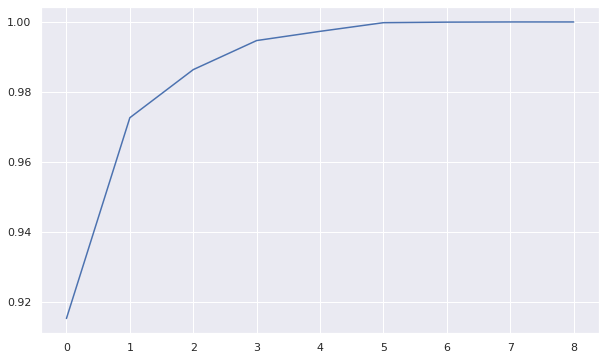

In [82]:
import numpy as np
from sklearn.decomposition import PCA

#Running a basic model with all the features with using PCA to reduce correlated features
x = sdf_model.drop(columns=['GDP_Per_Capita_Growth'])
y = sdf_model[['GDP_Per_Capita_Growth']]
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size = 0.8, random_state=6)
pca = PCA()
pca_x_train = pca.fit(x)
plt.plot(np.arange(0, len(pca.explained_variance_ratio_)), np.cumsum(pca.explained_variance_ratio_))
plt.show()


Based on the plot, it seems that the appropriate number of components to pick is 6, so we pick that and then compute RMSE and R^2 on the updated model

In [83]:
pca = PCA(n_components=6)
x_train = pca.fit_transform(x_train)
x_test = pca.transform(x_test)

model_2 =  LinearRegression()
model_2.fit(x_train, y_train)
y_pred = model_2.predict(x_test)

print('PCA Linear Regression Model RMSE: ' + str(np.sqrt(mean_squared_error(y_test, y_pred))))
print('PCA Linear Regression Model R^2: ' + str(model_2.score(x_test, y_test)))

PCA Linear Regression Model RMSE: 3.50370877611902
PCA Linear Regression Model R^2: 0.4382445885886209


Even with PCA, our RMSE and R^2 do not seem to change much from that of the orginial linear regression model. This actually makes sense since in Section 3.3, we found out that a majority of the features were not really that correlated based on the correlation matrix that we plotted. Thus, PCA was ineffective since we only have 9 features and a good number of them were uncorrelated with each other to begin with. If we had a lot more features and data that with more correlation, then PCA could have had a significant impact

###4.3 Neural Network - One Last Trick

We have one more trick up our sleeve and that is using a basic neural network to see if it reduces the RMSE or increases R^2. For our FNN model, we decided to use an MSE loss function as oppossed to the cross entropy loss function because we are dealing with regression and not classification. Furthermore, this allows us to compare the RMSE value of the neural network with the linear regression models from the previous parts. Let's see how it works

In [84]:
from sklearn.neural_network import MLPRegressor 

x = sdf_model.drop(columns=['GDP_Per_Capita_Growth'])
y = sdf_model[['GDP_Per_Capita_Growth']]
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size = 0.8, random_state=6)

neural_net = MLPRegressor(hidden_layer_sizes=(6, 4), activation='relu', solver='adam')
neural_net.fit(x_train, y_train.values.ravel())
predictions = neural_net.predict(x_test)

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [85]:
from sklearn.metrics import mean_squared_error, r2_score

rmse = np.sqrt(mean_squared_error(y_test, predictions))
r_square = r2_score(y_test, predictions)
print("RMSE:", rmse)
print("R^2:", r_square)

RMSE: 4.641026749814995
R^2: 0.014357535593388149


So, it seems that a neural network is an extremely ineffective model for this dataset and our objective - the RMSE and R^2 were really terrible. We tried various parameters for this neural network model and there was virtually no improvement in the performance. This seems to suggest that increasing the complexity of the model is not appropriate for our goal since it seems to overfit or underfit the training data and result in a great deal of inaccuracy. Thus, the best model for our data is actually the very basic linear regression one.  

###4.4 Running Linear Regression Model on Subsets of Indicators

After learning that the basic linear regression model has the best performance, we want to use this model to dig deeper into our research question - which feature/indicator subgroups are the best are predicting growth in GDP per capita? We will be splitting all our 9 features into 3 subgroups - Climate Change, Social, and Healthcare. 

- Climate Change consists of CO2 Emissions, Forest Area & Urban Sprawl
- Social consists of Salaried Workers, Adolescent Fertility, Age Dependency Ratio
- Healthcare consists of Measles Vaccinations, Health Expenditure, and Tuberculosis Incidence

Below, you can observe the RMSE and R^2 for the model applied to each subgroup of features: 

In [86]:
#Basic Model with all Climate Change Features (3 features)
x = sdf_final[['CO2_Emission', 'Forest_Area', 'Urban_Sprawl']]
y = sdf_temp[['GDP_Per_Capita_Growth']]
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size = 0.8, random_state=6)

model =  LinearRegression()
model.fit(x_train, y_train)
y_pred = model.predict(x_test)

print('Climate Change Basic Linear Regression Model RMSE: ' + str(np.sqrt(mean_squared_error(y_test, y_pred))))
print('Climate Change Basic Linear Regression Model R-Squared: ' + str(model.score(x_test, y_test)))



Climate Change Basic Linear Regression Model RMSE: 4.604919382619689
Climate Change Basic Linear Regression Model R-Squared: 0.02963454845173452


In [87]:
#Basic Model with all Social Features (3 features)
x = sdf_final[['Salaried_Workers', 'Adolescent_Fertility', 'Age_Dependency_Ratio']]
y = sdf_temp[['GDP_Per_Capita_Growth']]
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size = 0.8, random_state=6)

model =  LinearRegression()
model.fit(x_train, y_train)
y_pred = model.predict(x_test)

print('Social Factors Basic Linear Regression Model RMSE: ' + str(np.sqrt(mean_squared_error(y_test, y_pred))))
print('Social Factors Basic Linear Regression Model R-Squared: ' + str(model.score(x_test, y_test)))

Social Factors Basic Linear Regression Model RMSE: 3.4662227934318635
Social Factors Basic Linear Regression Model R-Squared: 0.45020066486981836


In [88]:
#Basic Model with all Healthcare Features (3 features)
x = sdf_final[['Health_Expenditure', 'Measles_Vaccination', 'TB_Incidence']]
y = sdf_temp[['GDP_Per_Capita_Growth']]
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size = 0.8, random_state=6)

model =  LinearRegression()
model.fit(x_train, y_train)
y_pred = model.predict(x_test)

print('Healthcare Factors Basic Linear Regression Model RMSE: ' + str(np.sqrt(mean_squared_error(y_test, y_pred))))
print('Healthcare Factors Basic Linear Regression Model R-Squared: ' + str(model.score(x_test, y_test)))

Healthcare Factors Basic Linear Regression Model RMSE: 3.580369789943737
Healthcare Factors Basic Linear Regression Model R-Squared: 0.4133932841189476


Right off the bat, we can conclude that climate change features/indicators are very ineffective at predicting GDP per capita growth. On the other hand, both social and healthcare features are decent in predicting GDP per capita growth with social features having the lowest RMSE and highest R^2 compared to all the subgroups and the model with all 9 features. 

#Section 5: Conclusion and Next Steps

###5.1 Summary of Findings

Through this data science research project, our group wanted to find the impact of indicators such as health, climate change, and social factors on the growth of GDP per capita of least developed countries. We chose a specific subset of the countries - least developed - to avoid extreme generalization for our machine learning model so that we could yield meaningful results from it. 

After wrangling the data and conducting exploratory analysis through visualization, we transformed the data to be suitable for a model. In order to make predictions, we inputted the data in a simple linear regression model, 3 models with regularized data, a model with PCA done on the data, and a simple neural network. Through using root mean squared error and R2 as metrics for our performance, we found out that the basic linear regression model was the most effective at predicting GDP per capita growth. A reason for this could be that a complex model such as FNN  tended to overfit or underfit the data a lot more than it needed to. 

Once we found out that the basic linear regression model was the most effective, we then split our features into 3 subsets based on whether they fell into the following categories - climate change, healthcare, social factors - and used features from each subgroup to predict GDP per capita growth. We found out that social factors were the best predictors of GDP per capita growth while climate change features were the worst predictors for GDP per capita growth. This makes sense because the features we chose for social factors has the most clear connection to employment and overall economic context. Additionally, the features we chose for healthcare also correlate reasonably well since they directly contribute to the well being of the working population, but might not do as well due to the increasing democratization of basic medicines. On the other hand, climate change seems to have weaker correlation with GDP growth per capita. 

Even so, with an RMSE of around 3.5 and R2 of around 0.45 for our best model, there is still a lot of room for improvement. We will talk about next steps and other ways to potentially improve the accuracy of our model in Section 5.3. 

###5.2 Challenges and Obstacles (Apart from Whining)

Our initially proposed project aimed to analyze the correlation between climate change factors (e.g. annual temperature change, CO2 emissions) and the prevalence of infectious diseases in developing countries. The challenge we faced with this was that the relationship between climate and infectious diseases might be difficult to capture with just a handful of variables, especially when other factors like healthcare infrastructure and geography are likely to have more significant effects than climate change on disease. To address this, we planned to normalize the disease data using data on hospital beds per 1000 people, however, this might add additional confounding factors like general healthcare development disparities. 

Following this, we pivoted our project to focus on the impact of climate, social and health factors on the GDP growth of countries, a more general measure of development. This time, when choosing features, we made sure to find features that would likely have relatively significant correlation with GDP growth, such as primary school enrollment rates and healthcare expenditure per capita. 

When it came to selecting rows in our final joined dataframe to feed into our ML models, we found that dropping the rows with nulls left us with ~200 rows. This was due to the fact that there was missing data for many of the least developed countries for features such as primary school enrollment, secondary school enrollment and PM2.5 (only measured yearly from from 2010 onwards) etc. Due to the significant amount of missing data, and in particular missing data for entire years, instead of imputing the data and likely getting inaccurate estimates, we chose new features to use instead that had more complete data. This gave us 564 rows of data to use, a significant improvement from before.

After running our initial linear regression model, the R-squared value was very low, ranging from around 0.02-0.15 depending on how the test and train data were split. We hypothesized that the years affected by the Global Financial Crisis were likely causing atypical variance in the data so we removed data from the years 2007-2010 to account for this. Doing so dramatically improved our model’s R-squared value to over 0.4.

Overcoming all these challenges helped us realize that data science is not all about creating models and making predictions. In fact, a lot of the work is actually choosing the right data and preparing it accordingly to be fed into the model for accurate results. A more complex model can only do so much if the data itself is not appropriate. This project helps us put into perspective the idea that data science is not just crunching numbers or creating dataframes; a lot of it is subjective so decisions made along each step of the way need to be made reasonably and methodically. 


###5.3 Next Steps and Future Direction

There is certainly a lot of room for improvement given the performance of our best model. However, we know that the complexity of the model is not too much of an issue since as we increased the complexity, the model’s performance stayed about the same or even decreased. Thus, the majority of the improvement should come from the data itself. One possibility is that the features/indicators we picked were not accurate predictors for GDP per capita growth. 

Our project only looked at how three aspects (climate, social, health) influence GDP growth of least developed countries. Undoubtedly, there are many other aspects that influence a country’s development and growth, such as economic, educational and political factors. Our basic model with three factors was able to indicate notable correlation between these factors and GDP growth. A potential next step would be to incorporate a wider array of factors and features into the model to more comprehensively analyze the correlation between such features and growth and development of countries. Analysis can also be done to identify which of these features has the greatest impact on GDP growth. Furthermore, variations of the model could be made for differing subsets of countries, e.g. OECD countries, or individual countries.

An application of a model like this could be in government. Understanding how varying conditions of areas like healthcare, the environment and education influence growth can help governments make more informed decisions to effectively allocate budgets and resources to promote the development of their countries.
